# Train using balanced subsets of data - 448x448 Redux

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import collections

In [3]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
import os
import pickle

In [4]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, \
                          get_accuracy, analyze_confidence, accuracy_vs_threshold, \
                          show_incremental_accuracy,  analyze_low_confidence, \
                          plot_confusion_matrix_thresh, get_val_stats, model_cutter

In [5]:
#from pneumonia_loaders import *

In [6]:
from pneumonia_loaders import show_categories
from pneumonia_new_loader import get_db

# Config

In [7]:
model = models.resnet18
prefix = 'other_classifier18_448cut'
short_prefix = '18_448cut'
size=224
bs = 63

In [8]:
#path = Path()/'data'/'chest_xray'
#path = Path()/'data'/'chest_xray_224'
path = Path()/'data'/'chest_xray_448'
#path = Path()/'data'/'chest_xray_896'

model_dir = (Path()/'models').absolute()

path.ls()

[WindowsPath('data/chest_xray_448/data'),
 WindowsPath('data/chest_xray_448/models'),
 WindowsPath('data/chest_xray_448/test'),
 WindowsPath('data/chest_xray_448/train'),
 WindowsPath('data/chest_xray_448/val')]

In [9]:
model_dir

WindowsPath('C:/Users/ddwil/Documents/GitHub/ChestXRay/models')

# Code

In [10]:
def my_transforms():
    tfms = get_transforms(do_flip=True, flip_vert=False,
                          max_zoom=1.3, max_lighting=0.3)
    return tfms

In [11]:
def get_best_initial(N=2, name='best_initial', max_lr=None, **kwargs):
    best_stats = None
    learn = None
    for i in range(N):
        learn = get_learner(**kwargs)
        if max_lr is None:
            learn.fit_one_cycle(1)
        else:
            learn.fit_one_cycle(1, max_lr=max_lr)
        stats = get_val_stats(learn)
        if best_stats is None:
            print(f"initial best: {stats['loss']:0.4f}")
            best_stats = stats
            learn.save(name)
        elif stats['loss'] < best_stats['loss']:
            print(f"new best: {stats['loss']:0.4f} < prior best: {best_stats['loss']:0.4f}")
            best_stats = stats
            learn.save(name)
        else:
            print(f"ignore  : {stats['loss']:0.4f} > best: {best_stats['loss']:0.4f}")

    learn.load(name)
    return learn

In [12]:
def show_results(results, key=None, show_details=True, limit=None):
    if key is not None:
        results = [x for x in results if key in x[0]]
        
    if len(results) > 1:
        err = [stats['error_rate'] for key, stats in results]
        loss = [stats['loss'] for key, stats in results]
        title = 'Overall' if key is None else key
        
        print(f'{title:14}  Error -- best: {np.min(err):.3f}  med: {np.median(err):.3f}   Loss -- best: {np.min(loss):.3f}  med: {np.median(loss):.3f}')
        if not show_details: return
        print('')
    results = sorted(results, key=lambda x:x[1]['error_rate'])
    
    if limit is None: limit = len(results)
    for key, stats in results[:limit]:
        print(f"{key:20}  error_rate: {stats['error_rate']:.3f}   accuracy: {stats['accuracy']:.3f}   loss:{stats['loss']:.4f}")

In [13]:
def get_best_stats(learner):
    rec = learner.recorder
    keys = ['loss'] + rec.metrics_names
    results = []
    for i, loss in enumerate(rec.val_losses):
        entry = [loss] + [float(v) for v in rec.metrics[i]]
        results.append(dict(zip(keys, entry)))
    return sorted(results, key=lambda x:x['error_rate'])[0]

In [14]:
def do_train(key, cycles, ps=None, mixup=False, unfreeze=False, cut=None, **kwargs):
    global all_results
    if ps is None:
        learn = get_learner(cut=cut)
    else:
        learn = get_learner(ps=ps, cut=cut)
        key = f'{key}_ps_{ps}'
    if unfreeze == 'all':
        key = key + '_ufa' 
        learn.freeze()
    elif unfreeze:
        key = f'{key}_uf{unfreeze}' 
        learn.freeze_to(unfreeze)
    if mixup:
        learn = learn.mixup()
        key = key + '_m'
    if cut:
        key= f'{key}_cut{cut}'
    
    print(key)
    learn.fit_one_cycle(cycles, callbacks=[SaveModelCallback(learn, every='improvement', 
                                                             monitor='accuracy', name='best')], **kwargs)
    learn.recorder.plot_losses()
    plt.show()
    stats =  get_best_stats(learn)   
    learn.save(key)
    all_results.append([key, stats])
    return learn

In [15]:
def get_learner(db=None, unfreeze=False, cut=None, **kwargs):
    if db is None: db = data
    if cut:
        assert isinstance(cut, int)
        mc = partial(model_cutter, select= [cut])
        my_split_on = lambda m: (m[0][cut],m[1])
        #def my_split_on(m): return (m[0][cut],m[1])
        learn = cnn_learner(db, model, metrics=[error_rate, accuracy], 
                            cut=mc, split_on=my_split_on,
                            model_dir=model_dir, **kwargs).to_fp16()
    else:
        learn = cnn_learner(db, model, metrics=[error_rate, accuracy], 
                        model_dir=model_dir, **kwargs).to_fp16()
    return learn

In [16]:
def get_params(all_lr=[1e-2, 3e-3, 1e-3], all_cycles=[1,2,4, 8]):
    global short_prefix
    for lr in all_lr:
        for cycles in all_cycles:
            key = f'{short_prefix}_lr_{lr}_cyc_{cycles}'
            yield key, {'cycles':cycles, 'max_lr':lr}

In [17]:
def save_stats():
    global all_results, prefix
    fn = prefix + 'stats.p'
    with open(fn, 'wb') as f:
        pickle.dump(all_results, f)
        
def restore_stats():
    global all_results, prefix
    fn = prefix + 'stats.p'
    with open(fn, 'rb') as f:
        all_results = pickle.load(f)

In [18]:
def restore_learner(name, ps=0.5, compute_baseline=True):
    learn = get_learner(ps=ps)
    learn.load(name)
    
    if compute_baseline:
        base = learn.svalidate()
        base = {'loss': base[0], 'error_rate': float(base[1]), 'accuracy': float(base[2])}
    else:
        base = None
    return learn, base

def refine_learner(name, ps=0.8, lr=1e-6, cycles=16, **kwargs):
    learn, base = restore_learner(name, ps=ps)
    print('base:', base)
    learn.unfreeze()
    learn.fit_one_cycle(cycles, max_lr=slice(lr,lr),
                        callbacks=[SaveModelCallback(learn, every='improvement', 
                                   monitor='accuracy', name='best')], **kwargs)
    stats = get_best_stats(learn)
    
    if stats['error_rate'] < base['error_rate']:
        new_name = f'{name}_r_lr{lr}_c{cycles}_ps{ps}'
        print('keeping:', stats)
        return learn, stats, new_name
    else:
        print('ignoring:', stats)
        return None, None, None

In [19]:
def get_interp(name, use_tta=False):
    learn = get_learner()
    learn.load(name)
    interp = learn.to_fp32().interpret(tta=use_tta)
    return interp

def analyze_interp(interp, include_norm=True):
    interpretation_summary(interp)
    plot_confusion_matrix(interp)
    plt.show()
    if include_norm:
        plot_confusion_matrix(interp, normalize=True)
        plt.show()  

# Analysis

### Train Normal / Viral / Bacterial - 1000 samples each

In [20]:
#data = get_db_np(path, size=size, scale=10, tfms=my_transforms())
data = get_db(path, kind='nvb', n_samples=1000, scale=1, double_valid=True,
              size=size, bs=bs, tfms=my_transforms())
print('Training set:')
show_categories(data.train_ds.y)
print('\nValidation set:')
show_categories(data.valid_ds.y)

Training set:
  bacteria  :  1000     33.3%
  normal    :  1000     33.3%
  virus     :  1000     33.3%
  Total     :  3000

Validation set:
  bacteria  :   148     33.3%
  normal    :   148     33.3%
  virus     :   148     33.3%
  Total     :   444


In [21]:
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bacteria,virus,virus,bacteria,normal
Path: data\chest_xray_448;

Valid: LabelList (444 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,bacteria,virus,normal,normal
Path: data\chest_xray_448;

Test: None

In [22]:
restore_stats()
assert False

AssertionError: 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03 
Min loss divided by 10: 6.92E-03
Min numerical gradient: 1.74E-03  (smoothed)
Min numerical gradient: 4.37E-03
Min loss divided by 10: 5.75E-03


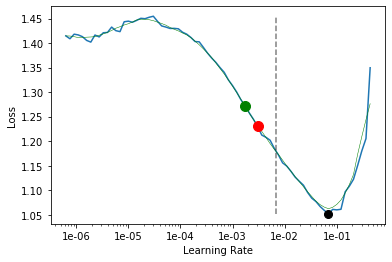

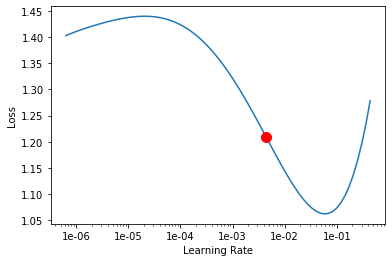

In [23]:
learn = get_learner()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [ ]:
learn = get_learner(cut=4)
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [ ]:
learn = get_learner(cut=5)
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

## Explore Baseline

In [ ]:
for c in [4, 5, 6, 7]:
    for key, params in get_params():
        do_train(key, cut=c, **params)
save_stats()

In [ ]:
for c in [4, 5, 6, 7]:
    for key, params in get_params(all_lr=[3e-4]):
        do_train(key, cut =c, **params)
save_stats()

## Reproduce best result for 224x224

18_224cut_lr_0.01_cyc_8

18_448cut_lr_0.01_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.772917,1.089297,0.328829,0.671171,00:32
1,0.655208,0.537849,0.186937,0.813063,00:32
2,0.608386,0.536034,0.180180,0.819820,00:32
3,0.571142,0.406283,0.132883,0.867117,00:32
4,0.536990,0.401535,0.128378,0.871622,00:32
5,0.501561,0.375519,0.123874,0.876126,00:32
6,0.461093,0.430511,0.123874,0.876126,00:32
7,0.425345,0.430384,0.128378,0.871622,00:32


Better model found at epoch 0 with accuracy value: 0.6711711883544922.
Better model found at epoch 1 with accuracy value: 0.8130631446838379.
Better model found at epoch 2 with accuracy value: 0.8198198080062866.
Better model found at epoch 3 with accuracy value: 0.867117166519165.
Better model found at epoch 4 with accuracy value: 0.8716216683387756.
Better model found at epoch 5 with accuracy value: 0.8761261701583862.


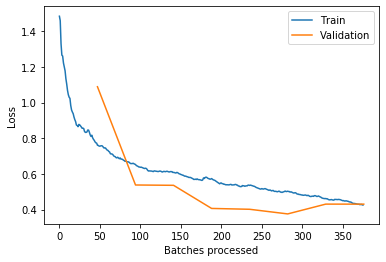

18_448cut_lr_0.01_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.860591,0.763789,0.238739,0.761261,00:32
1,0.698013,0.926958,0.310811,0.689189,00:32
2,0.633044,0.477345,0.173423,0.826577,00:32
3,0.577414,0.527090,0.209459,0.790541,00:32
4,0.535665,0.460055,0.144144,0.855856,00:32
5,0.476650,0.488046,0.141892,0.858108,00:32
6,0.456117,0.401449,0.123874,0.876126,00:32
7,0.439027,0.457790,0.144144,0.855856,00:32


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 2 with accuracy value: 0.8265765905380249.
Better model found at epoch 4 with accuracy value: 0.8558559417724609.
Better model found at epoch 5 with accuracy value: 0.8581081628799438.
Better model found at epoch 6 with accuracy value: 0.8761261701583862.


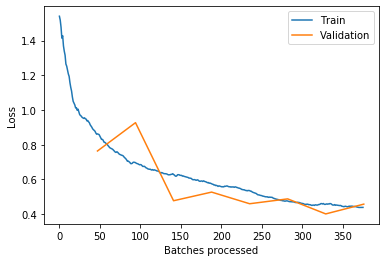

18_448cut_lr_0.01_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.848112,0.865841,0.333333,0.666667,00:32
1,0.676788,0.638914,0.184685,0.815315,00:32
2,0.609416,0.514480,0.139640,0.860360,00:32
3,0.556694,0.416153,0.137387,0.862613,00:32
4,0.515969,0.637525,0.218468,0.781532,00:32
5,0.479339,0.372208,0.105856,0.894144,00:32
6,0.444866,0.457405,0.139640,0.860360,00:32
7,0.424478,0.437073,0.137387,0.862613,00:32


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 1 with accuracy value: 0.815315306186676.
Better model found at epoch 2 with accuracy value: 0.8603604435920715.
Better model found at epoch 3 with accuracy value: 0.8626126646995544.
Better model found at epoch 5 with accuracy value: 0.8941442370414734.


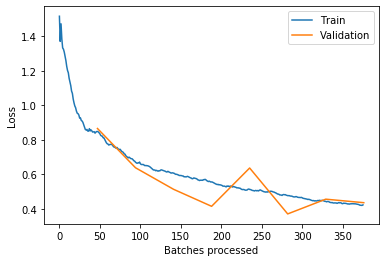

18_448cut_lr_0.01_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.821469,0.981468,0.310811,0.689189,00:32
1,0.678840,0.852783,0.407658,0.592342,00:32
2,0.616993,0.616845,0.211712,0.788288,00:32
3,0.557043,0.414136,0.114865,0.885135,00:32
4,0.513808,0.402566,0.121622,0.878378,00:32
5,0.485103,0.632957,0.202703,0.797297,00:32
6,0.458346,0.415819,0.114865,0.885135,00:32
7,0.427540,0.408849,0.119369,0.880631,00:32


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 2 with accuracy value: 0.7882882952690125.
Better model found at epoch 3 with accuracy value: 0.8851352334022522.


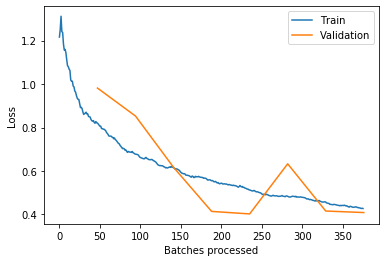

18_448cut_lr_0.01_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.812767,1.195617,0.416667,0.583333,00:32
1,0.691155,0.563843,0.182432,0.817568,00:32
2,0.618533,0.562166,0.175676,0.824324,00:32
3,0.556968,0.446592,0.146396,0.853604,00:32
4,0.522519,0.465242,0.139640,0.860360,00:32
5,0.481119,0.428573,0.137387,0.862613,00:32
6,0.456151,0.424469,0.132883,0.867117,00:32
7,0.431373,0.398519,0.114865,0.885135,00:32


Better model found at epoch 0 with accuracy value: 0.5833333134651184.
Better model found at epoch 1 with accuracy value: 0.8175676465034485.
Better model found at epoch 2 with accuracy value: 0.824324369430542.
Better model found at epoch 3 with accuracy value: 0.8536036610603333.
Better model found at epoch 4 with accuracy value: 0.8603603839874268.
Better model found at epoch 5 with accuracy value: 0.8626126646995544.
Better model found at epoch 6 with accuracy value: 0.867117166519165.
Better model found at epoch 7 with accuracy value: 0.8851352334022522.


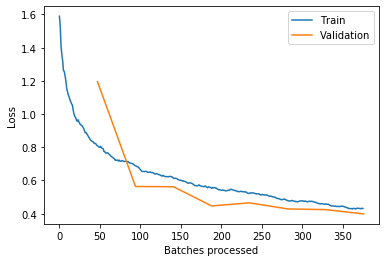

18_448cut_lr_0.01_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.818923,0.786245,0.247748,0.752252,00:32
1,0.682286,0.577367,0.186937,0.813063,00:32
2,0.617252,0.565554,0.207207,0.792793,00:32
3,0.565614,0.517801,0.159910,0.840090,00:33
4,0.512681,0.477407,0.159910,0.840090,00:32
5,0.494967,0.389554,0.112613,0.887387,00:32
6,0.463006,0.406095,0.126126,0.873874,00:32
7,0.432928,0.408109,0.117117,0.882883,00:32


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 1 with accuracy value: 0.8130631446838379.
Better model found at epoch 3 with accuracy value: 0.8400901556015015.
Better model found at epoch 5 with accuracy value: 0.8873874545097351.


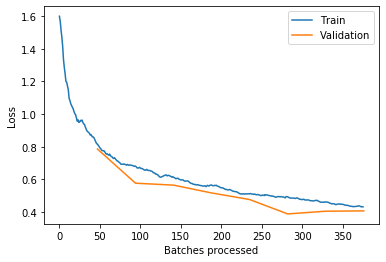

18_448cut_lr_0.01_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.830219,0.960797,0.299550,0.700450,00:32
1,0.703645,0.524279,0.191441,0.808559,00:32
2,0.632732,0.720451,0.252252,0.747748,00:32
3,0.562753,0.547479,0.195946,0.804054,00:32
4,0.515500,0.403863,0.139640,0.860360,00:32
5,0.482092,0.446892,0.164414,0.835586,00:32
6,0.447033,0.374323,0.112613,0.887387,00:32
7,0.422799,0.370512,0.103604,0.896396,00:32


Better model found at epoch 0 with accuracy value: 0.7004504799842834.
Better model found at epoch 1 with accuracy value: 0.8085585832595825.
Better model found at epoch 4 with accuracy value: 0.8603604435920715.
Better model found at epoch 6 with accuracy value: 0.8873874545097351.
Better model found at epoch 7 with accuracy value: 0.8963964581489563.


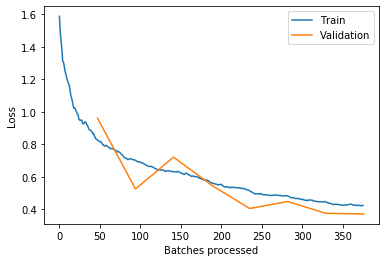

18_448cut_lr_0.01_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.858581,0.723072,0.247748,0.752252,00:32
1,0.684125,0.761251,0.243243,0.756757,00:32
2,0.626797,0.522737,0.195946,0.804054,00:32
3,0.569596,0.574386,0.222973,0.777027,00:32
4,0.535334,0.621539,0.202703,0.797297,00:32
5,0.494991,0.500988,0.146396,0.853604,00:32
6,0.455898,0.501333,0.168919,0.831081,00:32
7,0.435947,0.444138,0.141892,0.858108,00:32


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 1 with accuracy value: 0.7567567825317383.
Better model found at epoch 2 with accuracy value: 0.8040541410446167.
Better model found at epoch 5 with accuracy value: 0.8536036610603333.
Better model found at epoch 7 with accuracy value: 0.8581081628799438.


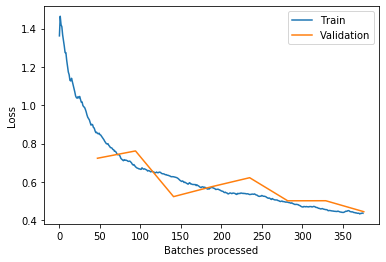

18_448cut_lr_0.01_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.773054,0.853675,0.355856,0.644144,00:32
1,0.654754,0.681327,0.227477,0.772523,00:32
2,0.589519,0.664408,0.295045,0.704955,00:32
3,0.541690,0.635653,0.216216,0.783784,00:32
4,0.512942,0.428284,0.117117,0.882883,00:32
5,0.487584,0.449250,0.137387,0.862613,00:32
6,0.449350,0.374555,0.112613,0.887387,00:32
7,0.438053,0.371600,0.112613,0.887387,00:32


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 1 with accuracy value: 0.772522509098053.
Better model found at epoch 3 with accuracy value: 0.7837837934494019.
Better model found at epoch 4 with accuracy value: 0.8828829526901245.
Better model found at epoch 6 with accuracy value: 0.8873874545097351.


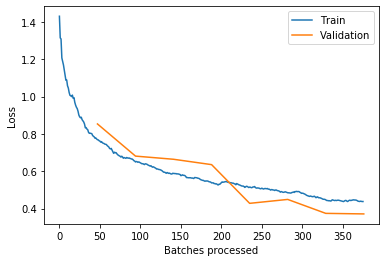

18_448cut_lr_0.01_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.839087,1.184991,0.405405,0.594595,00:32
1,0.688650,0.637807,0.238739,0.761261,00:32
2,0.623730,0.524943,0.182432,0.817568,00:32
3,0.562451,0.457106,0.130631,0.869369,00:32
4,0.540031,0.366457,0.108108,0.891892,00:32
5,0.493146,0.507708,0.175676,0.824324,00:32
6,0.458972,0.364425,0.101351,0.898649,00:32
7,0.433563,0.376068,0.108108,0.891892,00:32


Better model found at epoch 0 with accuracy value: 0.5945945978164673.
Better model found at epoch 1 with accuracy value: 0.7612612843513489.
Better model found at epoch 2 with accuracy value: 0.8175676465034485.
Better model found at epoch 3 with accuracy value: 0.8693694472312927.
Better model found at epoch 4 with accuracy value: 0.8918919563293457.
Better model found at epoch 6 with accuracy value: 0.898648738861084.


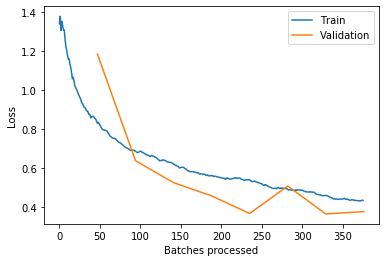

In [24]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
save_stats()

18_448cut_lr_0.01_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.793976,0.610971,0.229730,0.770270,00:32
1,0.656470,0.646207,0.240991,0.759009,00:32
2,0.567321,0.496549,0.126126,0.873874,00:32
3,0.503786,0.460199,0.137387,0.862613,00:32


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 2 with accuracy value: 0.8738739490509033.


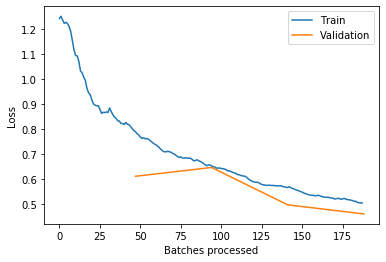

18_448cut_lr_0.01_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.814965,1.245392,0.457207,0.542793,00:32
1,0.663717,0.477502,0.157658,0.842342,00:32
2,0.565760,0.433194,0.130631,0.869369,00:32
3,0.505614,0.407399,0.119369,0.880631,00:32


Better model found at epoch 0 with accuracy value: 0.542792797088623.
Better model found at epoch 1 with accuracy value: 0.8423424363136292.
Better model found at epoch 2 with accuracy value: 0.8693694472312927.
Better model found at epoch 3 with accuracy value: 0.8806306719779968.


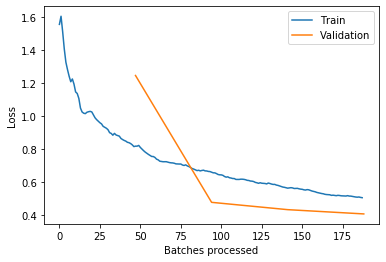

18_448cut_lr_0.01_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.814881,0.853991,0.265766,0.734234,00:32
1,0.681354,0.469541,0.139640,0.860360,00:32
2,0.578449,0.418631,0.112613,0.887387,00:32
3,0.514707,0.422416,0.108108,0.891892,00:32


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 1 with accuracy value: 0.8603604435920715.
Better model found at epoch 2 with accuracy value: 0.8873874545097351.
Better model found at epoch 3 with accuracy value: 0.8918919563293457.


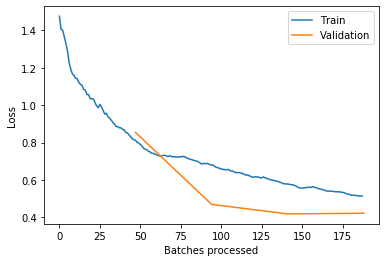

18_448cut_lr_0.01_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.768820,0.946214,0.349099,0.650901,00:32
1,0.656536,0.728258,0.236486,0.763514,00:32
2,0.576928,0.476317,0.137387,0.862613,00:32
3,0.504873,0.447503,0.128378,0.871622,00:32


Better model found at epoch 0 with accuracy value: 0.6509009003639221.
Better model found at epoch 1 with accuracy value: 0.7635135054588318.
Better model found at epoch 2 with accuracy value: 0.8626126646995544.
Better model found at epoch 3 with accuracy value: 0.8716216683387756.


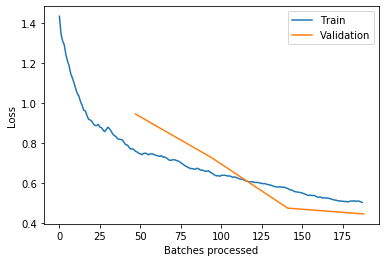

18_448cut_lr_0.01_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.797675,0.629867,0.213964,0.786036,00:32
1,0.657807,0.480786,0.189189,0.810811,00:32
2,0.570905,0.477314,0.150901,0.849099,00:32
3,0.521474,0.463164,0.144144,0.855856,00:35


Better model found at epoch 0 with accuracy value: 0.7860360145568848.
Better model found at epoch 1 with accuracy value: 0.8108108639717102.
Better model found at epoch 2 with accuracy value: 0.8490991592407227.
Better model found at epoch 3 with accuracy value: 0.8558559417724609.


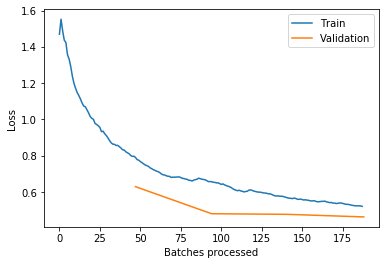

18_448cut_lr_0.01_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.833530,0.791043,0.335586,0.664414,00:32
1,0.656478,0.598398,0.250000,0.750000,00:32
2,0.575569,0.524929,0.164414,0.835586,00:32
3,0.510733,0.441269,0.141892,0.858108,00:32


Better model found at epoch 0 with accuracy value: 0.6644144058227539.
Better model found at epoch 1 with accuracy value: 0.75.
Better model found at epoch 2 with accuracy value: 0.8355855941772461.
Better model found at epoch 3 with accuracy value: 0.8581081628799438.


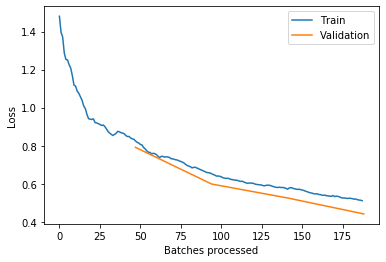

18_448cut_lr_0.01_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.800109,1.864929,0.572072,0.427928,00:34
1,0.661547,0.637415,0.245495,0.754505,00:33
2,0.576987,0.542343,0.191441,0.808559,00:32
3,0.511778,0.472883,0.157658,0.842342,00:32


Better model found at epoch 0 with accuracy value: 0.42792797088623047.
Better model found at epoch 1 with accuracy value: 0.7545045018196106.
Better model found at epoch 2 with accuracy value: 0.8085585832595825.
Better model found at epoch 3 with accuracy value: 0.8423424363136292.


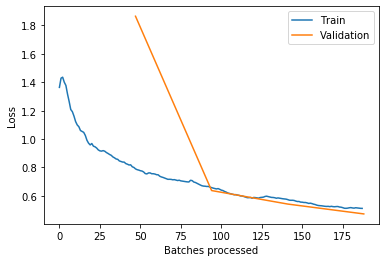

18_448cut_lr_0.01_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.805259,0.683782,0.272522,0.727477,00:32
1,0.661940,0.545550,0.171171,0.828829,00:32
2,0.575745,0.394197,0.105856,0.894144,00:32
3,0.516329,0.422138,0.119369,0.880631,00:32


Better model found at epoch 0 with accuracy value: 0.727477490901947.
Better model found at epoch 1 with accuracy value: 0.8288288116455078.
Better model found at epoch 2 with accuracy value: 0.8941442370414734.


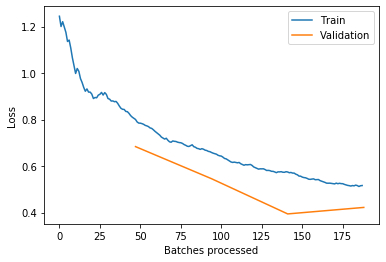

18_448cut_lr_0.01_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.810768,1.099395,0.358108,0.641892,00:32
1,0.652525,0.628989,0.184685,0.815315,00:32
2,0.557184,0.446586,0.103604,0.896396,00:32
3,0.506806,0.429627,0.103604,0.896396,00:32


Better model found at epoch 0 with accuracy value: 0.6418918967247009.
Better model found at epoch 1 with accuracy value: 0.815315306186676.
Better model found at epoch 2 with accuracy value: 0.8963964581489563.


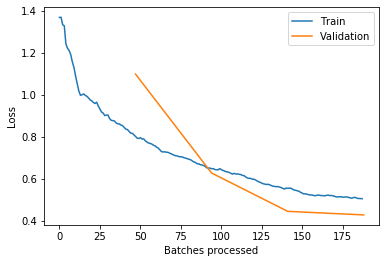

18_448cut_lr_0.01_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.787412,0.938739,0.308559,0.691441,00:32
1,0.669506,0.702750,0.256757,0.743243,00:32
2,0.577316,0.452931,0.137387,0.862613,00:32
3,0.507197,0.440613,0.132883,0.867117,00:32


Better model found at epoch 0 with accuracy value: 0.6914414167404175.
Better model found at epoch 1 with accuracy value: 0.7432432174682617.
Better model found at epoch 2 with accuracy value: 0.8626126646995544.
Better model found at epoch 3 with accuracy value: 0.867117166519165.


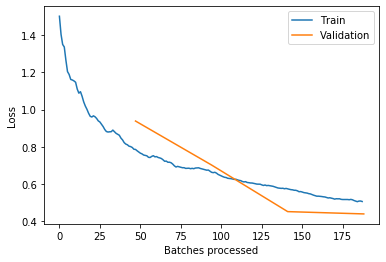

In [27]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
save_stats()

18_448cut_lr_0.01_cyc_12_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.834707,1.099155,0.367117,0.632883,00:32
1,0.695028,0.562938,0.168919,0.831081,00:32
2,0.607678,0.630657,0.222973,0.777027,00:32
3,0.575076,0.594763,0.202703,0.797297,00:32
4,0.552953,0.616723,0.200450,0.799550,00:32
5,0.521431,0.532028,0.168919,0.831081,00:32
6,0.492028,0.502087,0.171171,0.828829,00:32
7,0.465018,0.399267,0.130631,0.869369,00:32
8,0.447145,0.453486,0.144144,0.855856,00:32
9,0.427726,0.402279,0.112613,0.887387,00:32


Better model found at epoch 0 with accuracy value: 0.6328828930854797.
Better model found at epoch 1 with accuracy value: 0.8310811519622803.
Better model found at epoch 7 with accuracy value: 0.8693694472312927.
Better model found at epoch 9 with accuracy value: 0.8873874545097351.
Better model found at epoch 10 with accuracy value: 0.8896397352218628.
Better model found at epoch 11 with accuracy value: 0.8918919563293457.


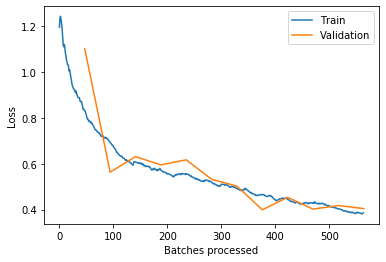

18_448cut_lr_0.01_cyc_12_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.880292,1.063975,0.407658,0.592342,00:32
1,0.696013,0.526619,0.168919,0.831081,00:32
2,0.636112,0.781594,0.274775,0.725225,00:32
3,0.591070,0.587573,0.191441,0.808559,00:32
4,0.551492,0.508421,0.159910,0.840090,00:32
5,0.530825,0.471648,0.139640,0.860360,00:32
6,0.498039,0.410212,0.119369,0.880631,00:32
7,0.471251,0.452169,0.130631,0.869369,00:32
8,0.443516,0.446070,0.135135,0.864865,00:32
9,0.413902,0.413699,0.126126,0.873874,00:32


Better model found at epoch 0 with accuracy value: 0.5923423171043396.
Better model found at epoch 1 with accuracy value: 0.8310811519622803.
Better model found at epoch 4 with accuracy value: 0.8400901556015015.
Better model found at epoch 5 with accuracy value: 0.8603604435920715.
Better model found at epoch 6 with accuracy value: 0.8806306719779968.


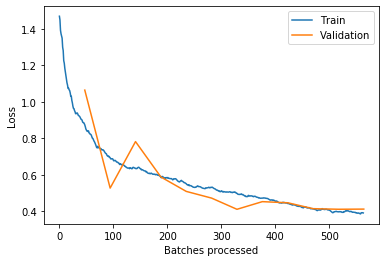

18_448cut_lr_0.01_cyc_12_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.820331,1.581285,0.511261,0.488739,00:32
1,0.703133,0.697771,0.247748,0.752252,00:32
2,0.634369,0.472835,0.150901,0.849099,00:32
3,0.596258,0.530055,0.164414,0.835586,00:32
4,0.561414,0.473550,0.139640,0.860360,00:32
5,0.533042,0.475607,0.148649,0.851351,00:32
6,0.498499,0.412231,0.132883,0.867117,00:32
7,0.470426,0.782059,0.263513,0.736486,00:33
8,0.443028,0.411854,0.123874,0.876126,00:33
9,0.421512,0.398299,0.114865,0.885135,00:32


Better model found at epoch 0 with accuracy value: 0.4887387454509735.
Better model found at epoch 1 with accuracy value: 0.7522522807121277.
Better model found at epoch 2 with accuracy value: 0.8490991592407227.
Better model found at epoch 4 with accuracy value: 0.8603604435920715.
Better model found at epoch 6 with accuracy value: 0.867117166519165.
Better model found at epoch 8 with accuracy value: 0.8761261701583862.
Better model found at epoch 9 with accuracy value: 0.8851352334022522.


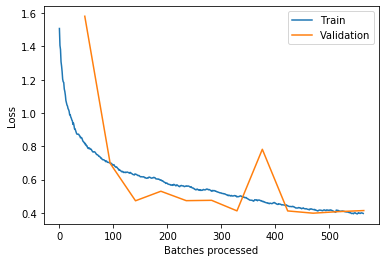

18_448cut_lr_0.01_cyc_12_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.840242,1.077032,0.416667,0.583333,00:32
1,0.688522,0.524384,0.164414,0.835586,00:32
2,0.606790,0.428772,0.128378,0.871622,00:32
3,0.582007,0.549847,0.193694,0.806306,00:32
4,0.544661,0.525033,0.184685,0.815315,00:32
5,0.525104,0.435855,0.141892,0.858108,00:32
6,0.491952,0.415899,0.137387,0.862613,00:32
7,0.466558,0.513224,0.171171,0.828829,00:32
8,0.444312,0.436529,0.146396,0.853604,00:32
9,0.427776,0.482435,0.157658,0.842342,00:32


Better model found at epoch 0 with accuracy value: 0.5833333134651184.
Better model found at epoch 1 with accuracy value: 0.8355856537818909.
Better model found at epoch 2 with accuracy value: 0.8716216683387756.


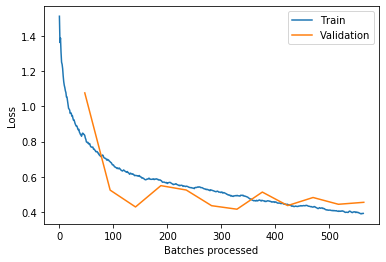

18_448cut_lr_0.01_cyc_12_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.853778,1.235695,0.432432,0.567568,00:32
1,0.700511,0.543353,0.191441,0.808559,00:32
2,0.616303,0.607732,0.193694,0.806306,00:32
3,0.589358,0.750514,0.272522,0.727477,00:32
4,0.534220,0.533831,0.150901,0.849099,00:32
5,0.508913,0.416373,0.123874,0.876126,00:32
6,0.476862,0.394422,0.126126,0.873874,00:32
7,0.465008,0.463782,0.159910,0.840090,00:32
8,0.452618,0.462433,0.139640,0.860360,00:32
9,0.420990,0.384700,0.112613,0.887387,00:32


Better model found at epoch 0 with accuracy value: 0.5675675868988037.
Better model found at epoch 1 with accuracy value: 0.8085585832595825.
Better model found at epoch 4 with accuracy value: 0.8490991592407227.
Better model found at epoch 5 with accuracy value: 0.8761261701583862.
Better model found at epoch 9 with accuracy value: 0.8873874545097351.


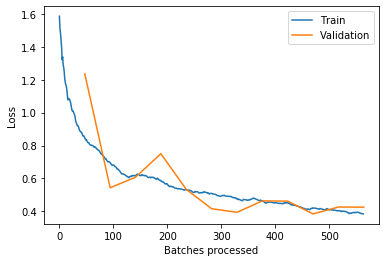

18_448cut_lr_0.01_cyc_12_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.846593,0.760713,0.274775,0.725225,00:32
1,0.707891,0.581100,0.189189,0.810811,00:32
2,0.624739,0.445398,0.128378,0.871622,00:32
3,0.593339,0.521699,0.189189,0.810811,00:32
4,0.560262,0.516234,0.175676,0.824324,00:32
5,0.512554,0.482389,0.157658,0.842342,00:32
6,0.482300,0.535994,0.162162,0.837838,00:32
7,0.457109,0.737988,0.250000,0.750000,00:32
8,0.444403,0.430326,0.148649,0.851351,00:32
9,0.416075,0.491272,0.157658,0.842342,00:32


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.
Better model found at epoch 2 with accuracy value: 0.8716216683387756.
Better model found at epoch 11 with accuracy value: 0.8738739490509033.


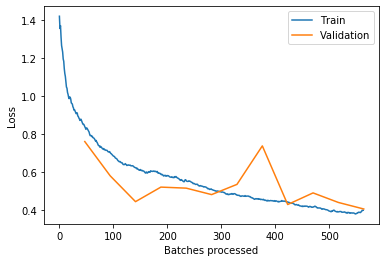

18_448cut_lr_0.01_cyc_12_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.836120,0.781285,0.254504,0.745495,00:32
1,0.673651,0.513070,0.139640,0.860360,00:32
2,0.620350,0.473949,0.177928,0.822072,00:32
3,0.601588,0.441451,0.150901,0.849099,00:32
4,0.550961,0.797901,0.295045,0.704955,00:32
5,0.516813,0.688706,0.207207,0.792793,00:32
6,0.499634,0.383799,0.126126,0.873874,00:32
7,0.469752,0.515760,0.150901,0.849099,00:32
8,0.454183,0.414924,0.139640,0.860360,00:32
9,0.416673,0.404260,0.121622,0.878378,00:32


Better model found at epoch 0 with accuracy value: 0.7454954981803894.
Better model found at epoch 1 with accuracy value: 0.8603604435920715.
Better model found at epoch 6 with accuracy value: 0.8738739490509033.
Better model found at epoch 9 with accuracy value: 0.8783784508705139.
Better model found at epoch 11 with accuracy value: 0.8806306719779968.


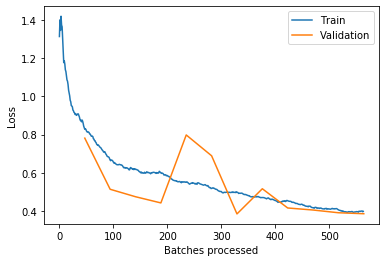

18_448cut_lr_0.01_cyc_12_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.825730,0.964452,0.292793,0.707207,00:32
1,0.686876,0.509885,0.155405,0.844595,00:32
2,0.631806,0.657795,0.283784,0.716216,00:32
3,0.590523,1.235007,0.369369,0.630631,00:32
4,0.558464,0.670206,0.274775,0.725225,00:32
5,0.515181,0.898452,0.369369,0.630631,00:32
6,0.495838,0.404670,0.135135,0.864865,00:32
7,0.466683,0.526396,0.175676,0.824324,00:32
8,0.451611,0.474749,0.157658,0.842342,00:32
9,0.427191,0.419778,0.126126,0.873874,00:32


Better model found at epoch 0 with accuracy value: 0.707207202911377.
Better model found at epoch 1 with accuracy value: 0.8445946574211121.
Better model found at epoch 6 with accuracy value: 0.8648649454116821.
Better model found at epoch 9 with accuracy value: 0.8738739490509033.


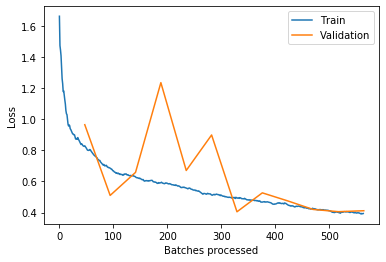

18_448cut_lr_0.01_cyc_12_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.882472,0.882121,0.308559,0.691441,00:32
1,0.699642,0.576081,0.173423,0.826577,00:32
2,0.628456,0.523988,0.159910,0.840090,00:32
3,0.601723,0.460438,0.130631,0.869369,00:32
4,0.564698,0.477969,0.128378,0.871622,00:32
5,0.518252,0.378641,0.119369,0.880631,00:32
6,0.498676,0.444204,0.121622,0.878378,00:32
7,0.460078,0.370974,0.105856,0.894144,00:32
8,0.438805,0.401130,0.117117,0.882883,00:32
9,0.428866,0.429492,0.128378,0.871622,00:32


Better model found at epoch 0 with accuracy value: 0.6914414167404175.
Better model found at epoch 1 with accuracy value: 0.8265765905380249.
Better model found at epoch 2 with accuracy value: 0.8400901556015015.
Better model found at epoch 3 with accuracy value: 0.8693694472312927.
Better model found at epoch 4 with accuracy value: 0.8716216683387756.
Better model found at epoch 5 with accuracy value: 0.8806306719779968.
Better model found at epoch 7 with accuracy value: 0.8941442370414734.


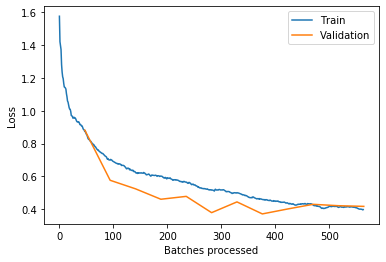

18_448cut_lr_0.01_cyc_12_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.823114,1.005838,0.412162,0.587838,00:32
1,0.697392,0.543521,0.191441,0.808559,00:32
2,0.611866,0.817698,0.304054,0.695946,00:33
3,0.578327,0.471005,0.123874,0.876126,00:32
4,0.543772,0.549751,0.184685,0.815315,00:32
5,0.520491,0.499467,0.150901,0.849099,00:32
6,0.496336,0.423665,0.137387,0.862613,00:32
7,0.463408,0.509642,0.171171,0.828829,00:32
8,0.440358,0.435346,0.164414,0.835586,00:32
9,0.430025,0.413542,0.146396,0.853604,00:32


Better model found at epoch 0 with accuracy value: 0.587837815284729.
Better model found at epoch 1 with accuracy value: 0.8085585832595825.
Better model found at epoch 3 with accuracy value: 0.8761261701583862.


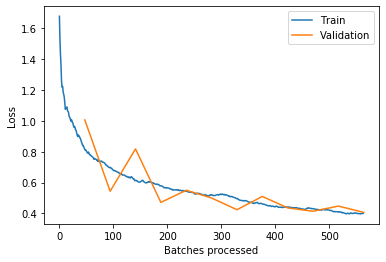

In [29]:
for i in range(10):
    for key, params in get_params(all_cycles=[12], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
save_stats()

18_448cut_lr_0.02_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.781979,0.958009,0.351351,0.648649,00:32
1,0.695038,1.067409,0.547297,0.452703,00:32
2,0.647226,0.528460,0.173423,0.826577,00:32
3,0.591800,0.485273,0.177928,0.822072,00:32
4,0.528523,0.400221,0.130631,0.869369,00:32
5,0.494716,0.679230,0.225225,0.774775,00:33
6,0.462221,0.435898,0.137387,0.862613,00:32
7,0.439912,0.400700,0.121622,0.878378,00:32


Better model found at epoch 0 with accuracy value: 0.6486486196517944.
Better model found at epoch 2 with accuracy value: 0.8265765905380249.
Better model found at epoch 4 with accuracy value: 0.8693694472312927.
Better model found at epoch 7 with accuracy value: 0.8783784508705139.


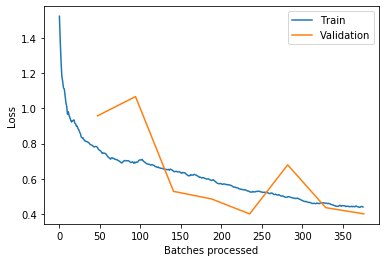

18_448cut_lr_0.02_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.811325,0.721110,0.234234,0.765766,00:32
1,0.696269,0.858456,0.245495,0.754505,00:32
2,0.650978,1.578382,0.479730,0.520270,00:32
3,0.602172,0.536273,0.171171,0.828829,00:32
4,0.542578,0.591167,0.175676,0.824324,00:32
5,0.508401,0.388862,0.112613,0.887387,00:32
6,0.469304,0.451967,0.137387,0.862613,00:32
7,0.439631,0.415884,0.130631,0.869369,00:32


Better model found at epoch 0 with accuracy value: 0.7657657861709595.
Better model found at epoch 3 with accuracy value: 0.8288288712501526.
Better model found at epoch 5 with accuracy value: 0.8873874545097351.


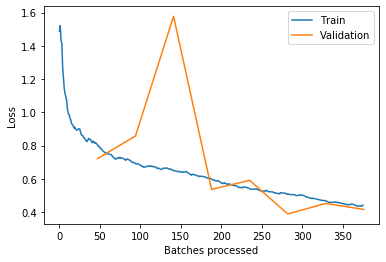

18_448cut_lr_0.02_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.796062,0.822305,0.277027,0.722973,00:32
1,0.694343,0.819394,0.265766,0.734234,00:32
2,0.656685,0.624489,0.306306,0.693694,00:32
3,0.593244,0.389575,0.112613,0.887387,00:32
4,0.537214,0.634222,0.234234,0.765766,00:32
5,0.501994,0.431088,0.135135,0.864865,00:32
6,0.469218,0.427731,0.139640,0.860360,00:32
7,0.450720,0.413736,0.144144,0.855856,00:32


Better model found at epoch 0 with accuracy value: 0.7229729890823364.
Better model found at epoch 1 with accuracy value: 0.7342342138290405.
Better model found at epoch 3 with accuracy value: 0.8873874545097351.


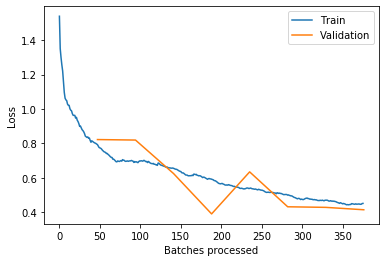

18_448cut_lr_0.02_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.813399,0.997687,0.389640,0.610360,00:32
1,0.690647,0.895484,0.369369,0.630631,00:32
2,0.651736,0.539495,0.186937,0.813063,00:32
3,0.615529,0.497335,0.173423,0.826577,00:32
4,0.553192,0.435524,0.121622,0.878378,00:32
5,0.506219,0.389712,0.112613,0.887387,00:32
6,0.465301,0.423014,0.119369,0.880631,00:32
7,0.439316,0.424905,0.119369,0.880631,00:32


Better model found at epoch 0 with accuracy value: 0.6103603839874268.
Better model found at epoch 1 with accuracy value: 0.630630612373352.
Better model found at epoch 2 with accuracy value: 0.8130630850791931.
Better model found at epoch 3 with accuracy value: 0.8265766501426697.
Better model found at epoch 4 with accuracy value: 0.8783784508705139.
Better model found at epoch 5 with accuracy value: 0.8873874545097351.


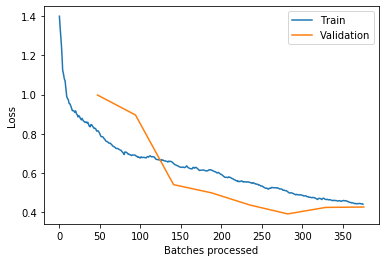

18_448cut_lr_0.02_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.840776,0.698820,0.308559,0.691441,00:32
1,0.710835,0.558845,0.198198,0.801802,00:32
2,0.639385,0.691521,0.259009,0.740991,00:32
3,0.607774,0.560160,0.236486,0.763514,00:32
4,0.540536,0.639905,0.220721,0.779279,00:32
5,0.504226,0.366862,0.128378,0.871622,00:32
6,0.455777,0.387938,0.114865,0.885135,00:32
7,0.426079,0.382542,0.110360,0.889640,00:32


Better model found at epoch 0 with accuracy value: 0.6914414167404175.
Better model found at epoch 1 with accuracy value: 0.801801860332489.
Better model found at epoch 5 with accuracy value: 0.8716216683387756.
Better model found at epoch 6 with accuracy value: 0.8851352334022522.
Better model found at epoch 7 with accuracy value: 0.8896397352218628.


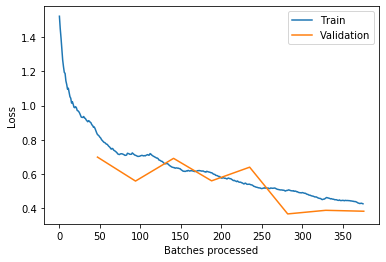

18_448cut_lr_0.02_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.754438,1.386226,0.373874,0.626126,00:32
1,0.672653,0.933617,0.324324,0.675676,00:32
2,0.659772,1.097608,0.360360,0.639640,00:32
3,0.600851,0.666682,0.204955,0.795045,00:32
4,0.552239,1.024970,0.299549,0.700450,00:32
5,0.500835,0.446241,0.121622,0.878378,00:32
6,0.471742,0.445215,0.137387,0.862613,00:32
7,0.449272,0.437278,0.130631,0.869369,00:32


Better model found at epoch 0 with accuracy value: 0.6261261105537415.
Better model found at epoch 1 with accuracy value: 0.6756756901741028.
Better model found at epoch 3 with accuracy value: 0.795045018196106.
Better model found at epoch 5 with accuracy value: 0.8783784508705139.


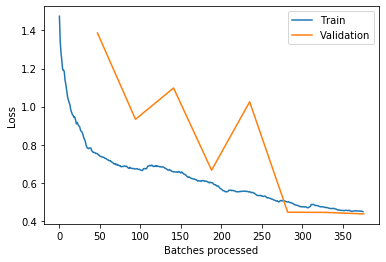

18_448cut_lr_0.02_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.791017,1.071815,0.326577,0.673423,00:32
1,0.687111,1.855299,0.414414,0.585586,00:32
2,0.674774,0.850954,0.443694,0.556306,00:32
3,0.605718,0.424965,0.148649,0.851351,00:32
4,0.554390,0.544524,0.207207,0.792793,00:32
5,0.514685,0.384507,0.103604,0.896396,00:32
6,0.463838,0.377230,0.105856,0.894144,00:32
7,0.431885,0.396100,0.119369,0.880631,00:32


Better model found at epoch 0 with accuracy value: 0.6734234094619751.
Better model found at epoch 3 with accuracy value: 0.8513514399528503.
Better model found at epoch 5 with accuracy value: 0.8963964581489563.


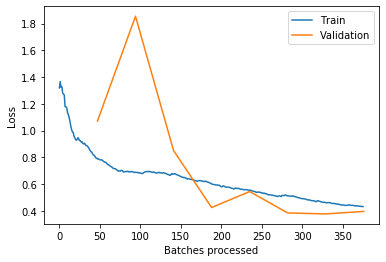

18_448cut_lr_0.02_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.840035,0.844278,0.317568,0.682432,00:32
1,0.684478,0.712982,0.277027,0.722973,00:32
2,0.665191,0.679275,0.236486,0.763514,00:32
3,0.582991,0.461547,0.135135,0.864865,00:32
4,0.545037,0.903695,0.373874,0.626126,00:32
5,0.502186,0.576061,0.148649,0.851351,00:32
6,0.467677,0.384118,0.105856,0.894144,00:32
7,0.441924,0.426342,0.112613,0.887387,00:32


Better model found at epoch 0 with accuracy value: 0.6824324131011963.
Better model found at epoch 1 with accuracy value: 0.7229729890823364.
Better model found at epoch 2 with accuracy value: 0.7635135054588318.
Better model found at epoch 3 with accuracy value: 0.8648649454116821.
Better model found at epoch 6 with accuracy value: 0.8941442370414734.


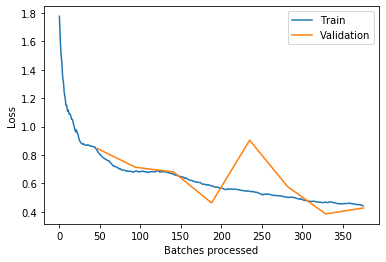

18_448cut_lr_0.02_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.828626,1.012723,0.450450,0.549550,00:32
1,0.694901,0.882962,0.283784,0.716216,00:32
2,0.678011,0.491435,0.164414,0.835586,00:32
3,0.594676,0.492858,0.144144,0.855856,00:32
4,0.538915,0.409728,0.135135,0.864865,00:32
5,0.493163,0.406370,0.114865,0.885135,00:32
6,0.457269,0.472595,0.148649,0.851351,00:32
7,0.427506,0.452482,0.144144,0.855856,00:32


Better model found at epoch 0 with accuracy value: 0.5495495200157166.
Better model found at epoch 1 with accuracy value: 0.7162162065505981.
Better model found at epoch 2 with accuracy value: 0.8355855941772461.
Better model found at epoch 3 with accuracy value: 0.8558559417724609.
Better model found at epoch 4 with accuracy value: 0.8648649454116821.
Better model found at epoch 5 with accuracy value: 0.8851352334022522.


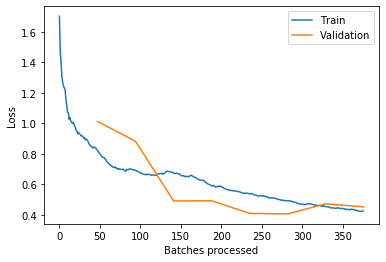

18_448cut_lr_0.02_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.780767,1.100962,0.310811,0.689189,00:32
1,0.693751,0.684862,0.245495,0.754505,00:32
2,0.675803,0.501155,0.148649,0.851351,00:32
3,0.599472,0.443376,0.108108,0.891892,00:32
4,0.527805,0.512347,0.159910,0.840090,00:32
5,0.482340,0.336811,0.094595,0.905405,00:32
6,0.464455,0.385638,0.101351,0.898649,00:32
7,0.434317,0.393193,0.110360,0.889640,00:32


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 1 with accuracy value: 0.7545045018196106.
Better model found at epoch 2 with accuracy value: 0.8513514399528503.
Better model found at epoch 3 with accuracy value: 0.8918919563293457.
Better model found at epoch 5 with accuracy value: 0.9054054617881775.


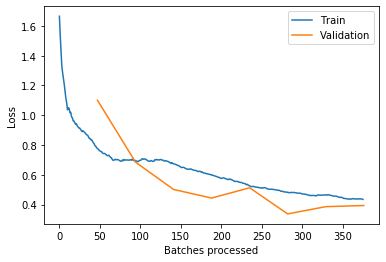

In [31]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
save_stats()

18_448cut_lr_0.02_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.780774,0.858697,0.355856,0.644144,00:32
1,0.693717,0.523379,0.162162,0.837838,00:32
2,0.588142,0.398462,0.121622,0.878378,00:32
3,0.515334,0.389378,0.110360,0.889640,00:32


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 1 with accuracy value: 0.8378379344940186.
Better model found at epoch 2 with accuracy value: 0.8783784508705139.
Better model found at epoch 3 with accuracy value: 0.8896397352218628.


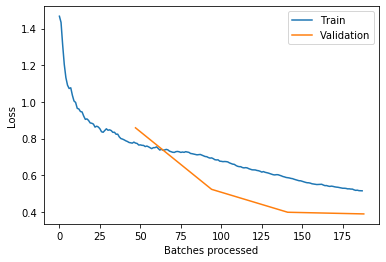

18_448cut_lr_0.02_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.805761,1.203173,0.488739,0.511261,00:32
1,0.706016,0.649178,0.243243,0.756757,00:34
2,0.598524,0.470416,0.175676,0.824324,00:32
3,0.535802,0.422071,0.128378,0.871622,00:32


Better model found at epoch 0 with accuracy value: 0.5112612843513489.
Better model found at epoch 1 with accuracy value: 0.7567567825317383.
Better model found at epoch 2 with accuracy value: 0.824324369430542.
Better model found at epoch 3 with accuracy value: 0.8716216683387756.


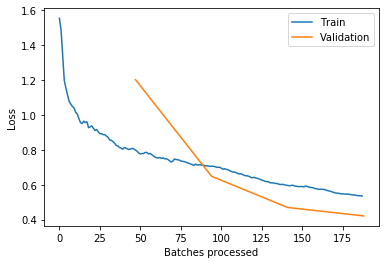

18_448cut_lr_0.02_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.757418,1.194674,0.488739,0.511261,00:32
1,0.657893,1.125738,0.319820,0.680180,00:33
2,0.587330,0.512543,0.175676,0.824324,00:33
3,0.523619,0.435442,0.137387,0.862613,00:33


Better model found at epoch 0 with accuracy value: 0.5112612843513489.
Better model found at epoch 1 with accuracy value: 0.6801801919937134.
Better model found at epoch 2 with accuracy value: 0.8243243098258972.
Better model found at epoch 3 with accuracy value: 0.8626126646995544.


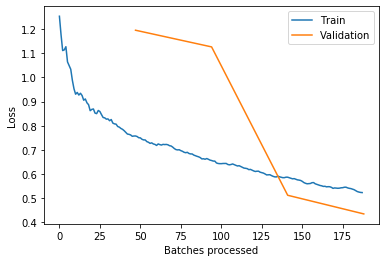

18_448cut_lr_0.02_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.775903,1.549787,0.569820,0.430180,00:32
1,0.691268,0.586598,0.209459,0.790541,00:32
2,0.594414,0.441956,0.137387,0.862613,00:32
3,0.531563,0.462626,0.144144,0.855856,00:32


Better model found at epoch 0 with accuracy value: 0.4301801919937134.
Better model found at epoch 1 with accuracy value: 0.7905405163764954.
Better model found at epoch 2 with accuracy value: 0.8626126646995544.


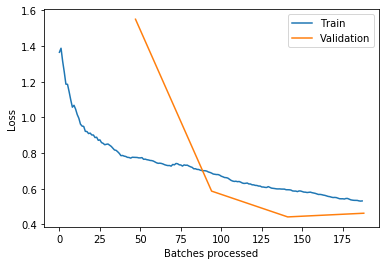

18_448cut_lr_0.02_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.789005,0.671645,0.245495,0.754505,00:32
1,0.676991,0.693876,0.333333,0.666667,00:32
2,0.585027,0.470024,0.123874,0.876126,00:32
3,0.523194,0.400941,0.117117,0.882883,00:32


Better model found at epoch 0 with accuracy value: 0.7545045018196106.
Better model found at epoch 2 with accuracy value: 0.8761261701583862.
Better model found at epoch 3 with accuracy value: 0.8828829526901245.


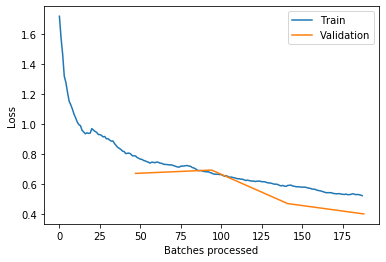

18_448cut_lr_0.02_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.781237,0.758505,0.254504,0.745495,00:32
1,0.690015,1.005269,0.387387,0.612613,00:32
2,0.606996,0.420314,0.128378,0.871622,00:33
3,0.527118,0.456393,0.123874,0.876126,00:32


Better model found at epoch 0 with accuracy value: 0.7454954981803894.
Better model found at epoch 2 with accuracy value: 0.8716216683387756.
Better model found at epoch 3 with accuracy value: 0.8761261701583862.


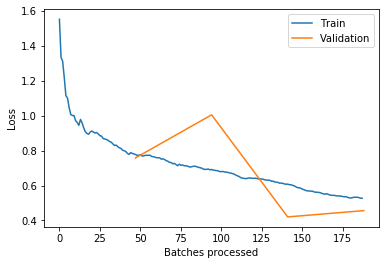

18_448cut_lr_0.02_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.814414,0.628148,0.220721,0.779279,00:32
1,0.703232,0.605512,0.247748,0.752252,00:32
2,0.606110,0.411762,0.128378,0.871622,00:32
3,0.530449,0.415242,0.105856,0.894144,00:32


Better model found at epoch 0 with accuracy value: 0.7792792916297913.
Better model found at epoch 2 with accuracy value: 0.8716216683387756.
Better model found at epoch 3 with accuracy value: 0.8941442370414734.


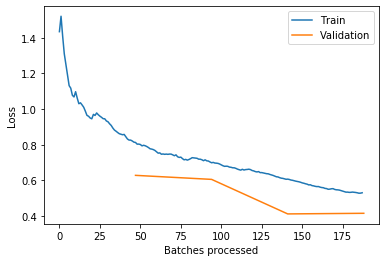

18_448cut_lr_0.02_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.798350,1.702344,0.527027,0.472973,00:32
1,0.704830,0.556507,0.180180,0.819820,00:32
2,0.630048,0.426226,0.130631,0.869369,00:32
3,0.533176,0.396863,0.123874,0.876126,00:32


Better model found at epoch 0 with accuracy value: 0.47297295928001404.
Better model found at epoch 1 with accuracy value: 0.8198198676109314.
Better model found at epoch 2 with accuracy value: 0.8693694472312927.
Better model found at epoch 3 with accuracy value: 0.8761261701583862.


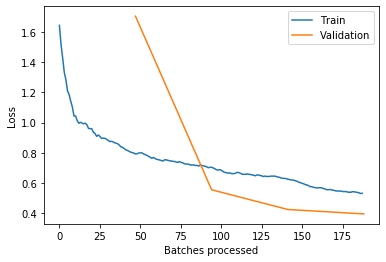

18_448cut_lr_0.02_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.769940,0.780494,0.358108,0.641892,00:32
1,0.701074,0.909065,0.389640,0.610360,00:32
2,0.594243,0.436125,0.146396,0.853604,00:32
3,0.526505,0.433003,0.139640,0.860360,00:32


Better model found at epoch 0 with accuracy value: 0.6418918967247009.
Better model found at epoch 2 with accuracy value: 0.8536036610603333.
Better model found at epoch 3 with accuracy value: 0.8603604435920715.


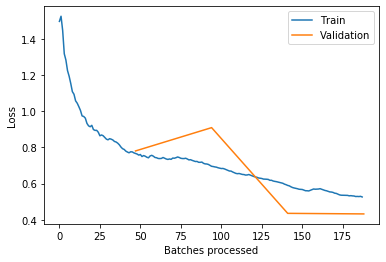

18_448cut_lr_0.02_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.768533,0.856065,0.313063,0.686937,00:32
1,0.667835,1.154577,0.389640,0.610360,00:32
2,0.599234,0.404599,0.117117,0.882883,00:32
3,0.523087,0.424589,0.121622,0.878378,00:32


Better model found at epoch 0 with accuracy value: 0.6869369149208069.
Better model found at epoch 2 with accuracy value: 0.8828829526901245.


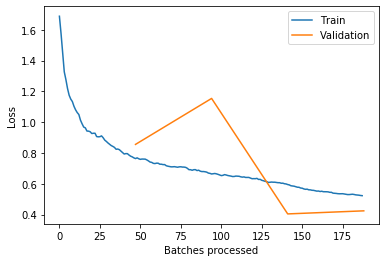

In [33]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
save_stats()

18_448cut_lr_0.03_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.819718,0.651768,0.236486,0.763514,00:32
1,0.701915,3.362659,0.646396,0.353604,00:32
2,0.696865,0.812073,0.252252,0.747748,00:32
3,0.610599,0.565900,0.200450,0.799550,00:32
4,0.552571,0.471480,0.148649,0.851351,00:32
5,0.509302,0.525583,0.171171,0.828829,00:32
6,0.475040,0.418875,0.126126,0.873874,00:32
7,0.457315,0.403647,0.126126,0.873874,00:32


Better model found at epoch 0 with accuracy value: 0.7635135054588318.
Better model found at epoch 3 with accuracy value: 0.7995495200157166.
Better model found at epoch 4 with accuracy value: 0.8513514399528503.
Better model found at epoch 6 with accuracy value: 0.8738739490509033.


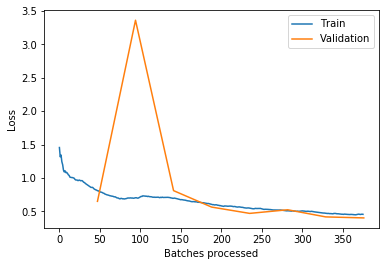

18_448cut_lr_0.03_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.799448,0.712019,0.209459,0.790541,00:32
1,0.721689,1.457453,0.518018,0.481982,00:32
2,0.674064,2.963298,0.477477,0.522523,00:32
3,0.612350,0.744057,0.243243,0.756757,00:32
4,0.554677,0.416956,0.137387,0.862613,00:33
5,0.514232,0.484865,0.153153,0.846847,00:32
6,0.473146,0.387863,0.101351,0.898649,00:32
7,0.441428,0.401715,0.112613,0.887387,00:32


Better model found at epoch 0 with accuracy value: 0.7905406355857849.
Better model found at epoch 4 with accuracy value: 0.8626126646995544.
Better model found at epoch 6 with accuracy value: 0.898648738861084.


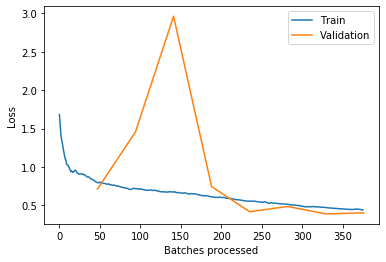

18_448cut_lr_0.03_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.776619,1.053200,0.407658,0.592342,00:32
1,0.706329,0.894065,0.306306,0.693694,00:32
2,0.685439,0.855654,0.272522,0.727477,00:32
3,0.607900,0.793245,0.263513,0.736486,00:32
4,0.557832,0.587792,0.227477,0.772523,00:32
5,0.508952,0.732866,0.247748,0.752252,00:32
6,0.460271,0.526313,0.186937,0.813063,00:32
7,0.437541,0.438231,0.135135,0.864865,00:32


Better model found at epoch 0 with accuracy value: 0.5923423171043396.
Better model found at epoch 1 with accuracy value: 0.6936936974525452.
Better model found at epoch 2 with accuracy value: 0.727477490901947.
Better model found at epoch 3 with accuracy value: 0.7364864945411682.
Better model found at epoch 4 with accuracy value: 0.772522509098053.
Better model found at epoch 6 with accuracy value: 0.8130631446838379.
Better model found at epoch 7 with accuracy value: 0.8648649454116821.


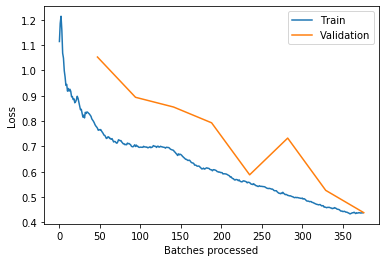

18_448cut_lr_0.03_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.773572,1.136765,0.412162,0.587838,00:32
1,0.697024,0.647972,0.182432,0.817568,00:33
2,0.658530,0.955168,0.297297,0.702703,00:32
3,0.616590,0.415660,0.144144,0.855856,00:32
4,0.568200,0.446148,0.175676,0.824324,00:32
5,0.524599,0.411991,0.128378,0.871622,00:32
6,0.465309,0.398199,0.128378,0.871622,00:32
7,0.445226,0.367009,0.110360,0.889640,00:32


Better model found at epoch 0 with accuracy value: 0.587837815284729.
Better model found at epoch 1 with accuracy value: 0.8175675868988037.
Better model found at epoch 3 with accuracy value: 0.8558559417724609.
Better model found at epoch 5 with accuracy value: 0.8716216683387756.
Better model found at epoch 7 with accuracy value: 0.8896397352218628.


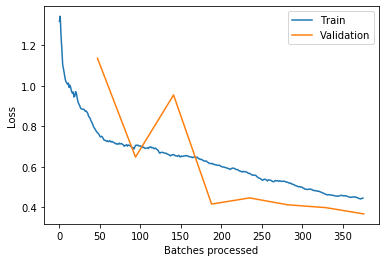

18_448cut_lr_0.03_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.819971,0.910609,0.394144,0.605856,00:32
1,0.709794,0.463934,0.164414,0.835586,00:33
2,0.682894,0.544771,0.168919,0.831081,00:32
3,0.619027,0.593932,0.254504,0.745495,00:32
4,0.552503,0.404327,0.112613,0.887387,00:34
5,0.520308,0.472763,0.148649,0.851351,00:32
6,0.474903,0.386729,0.126126,0.873874,00:32
7,0.445005,0.411188,0.137387,0.862613,00:32


Better model found at epoch 0 with accuracy value: 0.6058558821678162.
Better model found at epoch 1 with accuracy value: 0.8355856537818909.
Better model found at epoch 4 with accuracy value: 0.8873874545097351.


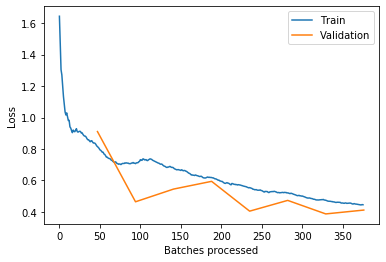

18_448cut_lr_0.03_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.753791,1.418914,0.432432,0.567568,00:32
1,0.730965,2.867679,0.527027,0.472973,00:32
2,0.678201,0.927428,0.324324,0.675676,00:32
3,0.604689,0.877935,0.297297,0.702703,00:32
4,0.544281,0.459901,0.198198,0.801802,00:32
5,0.514218,0.430957,0.135135,0.864865,00:32
6,0.483357,0.412117,0.132883,0.867117,00:32
7,0.443935,0.418181,0.137387,0.862613,00:33


Better model found at epoch 0 with accuracy value: 0.5675675868988037.
Better model found at epoch 2 with accuracy value: 0.6756756901741028.
Better model found at epoch 3 with accuracy value: 0.7027027010917664.
Better model found at epoch 4 with accuracy value: 0.801801860332489.
Better model found at epoch 5 with accuracy value: 0.8648649454116821.
Better model found at epoch 6 with accuracy value: 0.867117166519165.


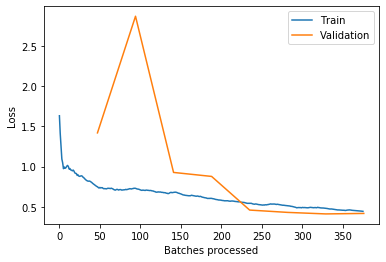

18_448cut_lr_0.03_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.805142,0.687132,0.236486,0.763514,00:32
1,0.698157,1.267483,0.389640,0.610360,00:32
2,0.674478,0.766110,0.268018,0.731982,00:32
3,0.624241,0.589160,0.222973,0.777027,00:32
4,0.556166,0.523746,0.198198,0.801802,00:32
5,0.510079,0.407124,0.117117,0.882883,00:32
6,0.469313,0.408825,0.135135,0.864865,00:32
7,0.439682,0.398114,0.128378,0.871622,00:32


Better model found at epoch 0 with accuracy value: 0.7635135054588318.
Better model found at epoch 3 with accuracy value: 0.7770270109176636.
Better model found at epoch 4 with accuracy value: 0.801801860332489.
Better model found at epoch 5 with accuracy value: 0.8828829526901245.


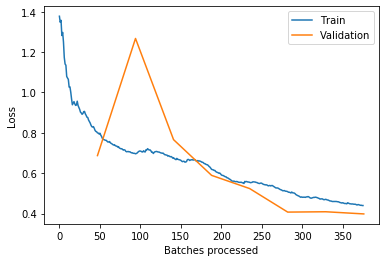

18_448cut_lr_0.03_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.751716,1.035638,0.333333,0.666667,00:32
1,0.731283,0.662189,0.220721,0.779279,00:32
2,0.688025,0.895772,0.324324,0.675676,00:32
3,0.632771,0.553944,0.182432,0.817568,00:32
4,0.561959,0.711507,0.277027,0.722973,00:32
5,0.511115,0.403479,0.119369,0.880631,00:32
6,0.483024,0.411995,0.126126,0.873874,00:32
7,0.447488,0.424459,0.123874,0.876126,00:32


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 3 with accuracy value: 0.8175676465034485.
Better model found at epoch 5 with accuracy value: 0.8806306719779968.


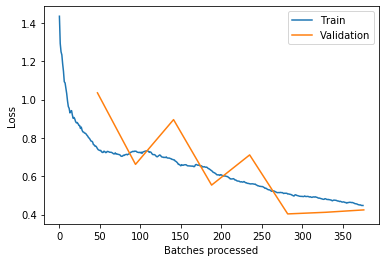

18_448cut_lr_0.03_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.791851,0.643332,0.252252,0.747748,00:32
1,0.722180,0.995417,0.367117,0.632883,00:32
2,0.673560,0.648638,0.236486,0.763514,00:32
3,0.601116,0.870170,0.304054,0.695946,00:32
4,0.564386,0.708002,0.247748,0.752252,00:32
5,0.526352,0.410898,0.123874,0.876126,00:32
6,0.470805,0.504417,0.159910,0.840090,00:32
7,0.436148,0.492270,0.159910,0.840090,00:32


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.7635135054588318.
Better model found at epoch 5 with accuracy value: 0.8761261701583862.


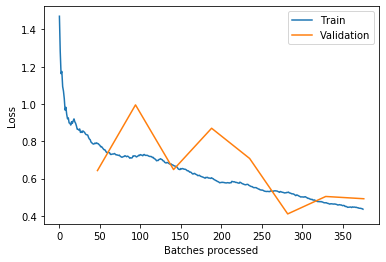

18_448cut_lr_0.03_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.737479,0.783500,0.274775,0.725225,00:32
1,0.684074,1.899988,0.448198,0.551802,00:32
2,0.659145,0.660042,0.324324,0.675676,00:32
3,0.609115,0.438892,0.148649,0.851351,00:32
4,0.553076,0.497793,0.157658,0.842342,00:32
5,0.508814,0.375212,0.112613,0.887387,00:32
6,0.468506,0.435654,0.117117,0.882883,00:32
7,0.445568,0.442264,0.114865,0.885135,00:32


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 3 with accuracy value: 0.8513514399528503.
Better model found at epoch 5 with accuracy value: 0.8873874545097351.


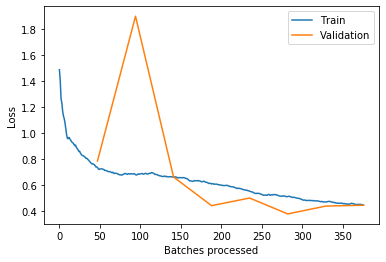

In [67]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
save_stats()

18_448cut_lr_0.03_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.781315,2.576972,0.619369,0.380631,00:32
1,0.734475,0.510736,0.168919,0.831081,00:32
2,0.619915,0.448612,0.150901,0.849099,00:32
3,0.547393,0.432663,0.123874,0.876126,00:32


Better model found at epoch 0 with accuracy value: 0.38063064217567444.
Better model found at epoch 1 with accuracy value: 0.8310810923576355.
Better model found at epoch 2 with accuracy value: 0.8490991592407227.
Better model found at epoch 3 with accuracy value: 0.8761261701583862.


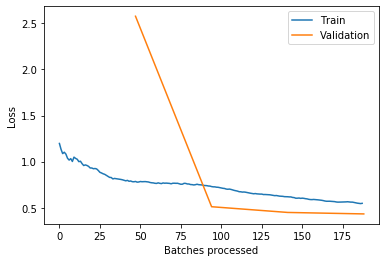

18_448cut_lr_0.03_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.789412,1.943991,0.475225,0.524775,00:32
1,0.717407,0.895256,0.385135,0.614865,00:32
2,0.630723,0.496540,0.164414,0.835586,00:32
3,0.553104,0.419581,0.126126,0.873874,00:32


Better model found at epoch 0 with accuracy value: 0.5247747898101807.
Better model found at epoch 1 with accuracy value: 0.6148648858070374.
Better model found at epoch 2 with accuracy value: 0.8355856537818909.
Better model found at epoch 3 with accuracy value: 0.8738739490509033.


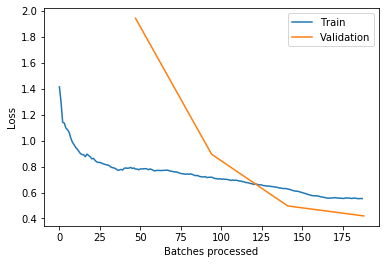

18_448cut_lr_0.03_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.765254,1.710954,0.556306,0.443694,00:32
1,0.740863,0.738786,0.317568,0.682432,00:32
2,0.622845,0.584389,0.189189,0.810811,00:32
3,0.535173,0.397741,0.101351,0.898649,00:33


Better model found at epoch 0 with accuracy value: 0.44369369745254517.
Better model found at epoch 1 with accuracy value: 0.6824324131011963.
Better model found at epoch 2 with accuracy value: 0.8108108639717102.
Better model found at epoch 3 with accuracy value: 0.898648738861084.


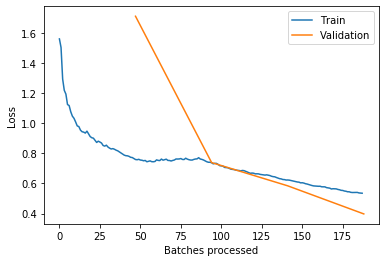

18_448cut_lr_0.03_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.786155,1.359999,0.412162,0.587838,00:32
1,0.731182,1.011043,0.385135,0.614865,00:32
2,0.631801,0.485151,0.146396,0.853604,00:32
3,0.536653,0.413236,0.112613,0.887387,00:32


Better model found at epoch 0 with accuracy value: 0.587837815284729.
Better model found at epoch 1 with accuracy value: 0.6148648858070374.
Better model found at epoch 2 with accuracy value: 0.8536036610603333.
Better model found at epoch 3 with accuracy value: 0.8873874545097351.


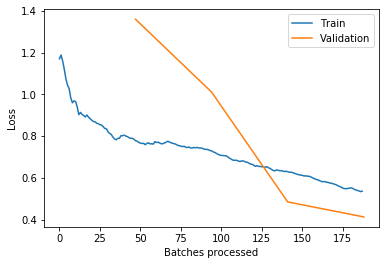

18_448cut_lr_0.03_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.789850,2.061608,0.581081,0.418919,00:32
1,0.721857,0.531197,0.180180,0.819820,00:32
2,0.618585,0.442718,0.148649,0.851351,00:32
3,0.525680,0.514046,0.164414,0.835586,00:32


Better model found at epoch 0 with accuracy value: 0.4189189672470093.
Better model found at epoch 1 with accuracy value: 0.8198198080062866.
Better model found at epoch 2 with accuracy value: 0.8513514399528503.


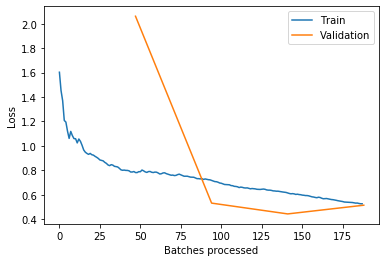

18_448cut_lr_0.03_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.778787,1.766999,0.527027,0.472973,00:33
1,0.720241,0.563686,0.182432,0.817568,00:32
2,0.619147,0.470928,0.137387,0.862613,00:32
3,0.550057,0.467200,0.155405,0.844595,00:32


Better model found at epoch 0 with accuracy value: 0.4729730188846588.
Better model found at epoch 1 with accuracy value: 0.8175676465034485.
Better model found at epoch 2 with accuracy value: 0.8626126646995544.


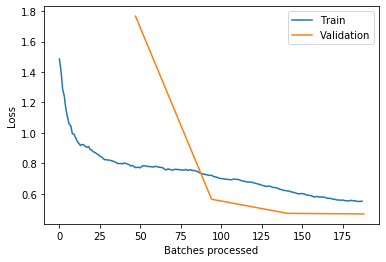

18_448cut_lr_0.03_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.792175,0.724474,0.306306,0.693694,00:33
1,0.713068,0.658985,0.227477,0.772523,00:33
2,0.628231,0.431236,0.132883,0.867117,00:33
3,0.541701,0.409064,0.123874,0.876126,00:33


Better model found at epoch 0 with accuracy value: 0.6936936974525452.
Better model found at epoch 1 with accuracy value: 0.772522509098053.
Better model found at epoch 2 with accuracy value: 0.867117166519165.
Better model found at epoch 3 with accuracy value: 0.8761261701583862.


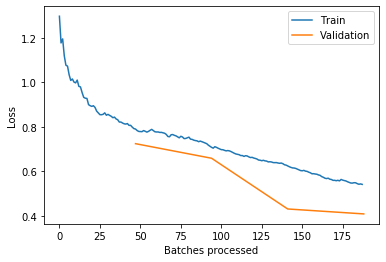

18_448cut_lr_0.03_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.794844,0.822561,0.355856,0.644144,00:32
1,0.762540,1.128503,0.394144,0.605856,00:32
2,0.627271,0.485906,0.139640,0.860360,00:32
3,0.536662,0.456437,0.144144,0.855856,00:32


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 2 with accuracy value: 0.8603604435920715.


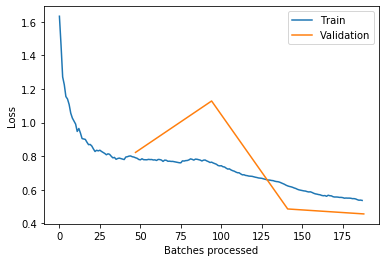

18_448cut_lr_0.03_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.785075,1.540020,0.547297,0.452703,00:32
1,0.700074,0.527174,0.164414,0.835586,00:32
2,0.604572,0.471323,0.119369,0.880631,00:32
3,0.545328,0.466341,0.141892,0.858108,00:32


Better model found at epoch 0 with accuracy value: 0.45270270109176636.
Better model found at epoch 1 with accuracy value: 0.8355856537818909.
Better model found at epoch 2 with accuracy value: 0.8806306719779968.


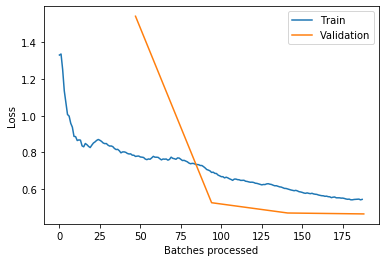

18_448cut_lr_0.03_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.813821,0.961407,0.324324,0.675676,00:32
1,0.733514,1.153067,0.380631,0.619369,00:32
2,0.636298,0.464974,0.146396,0.853604,00:32
3,0.542340,0.436153,0.121622,0.878378,00:32


Better model found at epoch 0 with accuracy value: 0.6756756901741028.
Better model found at epoch 2 with accuracy value: 0.8536036610603333.
Better model found at epoch 3 with accuracy value: 0.8783784508705139.


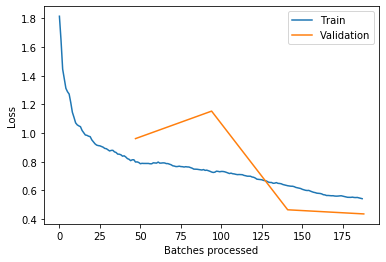

In [71]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
save_stats()

18_448cut_lr_0.02_cyc_8_i0_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.984310,0.805965,0.328829,0.671171,00:33
1,0.876863,0.535764,0.202703,0.797297,00:32
2,0.833338,0.593966,0.202703,0.797297,00:32
3,0.771075,0.590292,0.177928,0.822072,00:32
4,0.732569,0.446720,0.128378,0.871622,00:32
5,0.703479,0.416949,0.117117,0.882883,00:32
6,0.678147,0.391217,0.099099,0.900901,00:32
7,0.658821,0.401520,0.103604,0.896396,00:32


Better model found at epoch 0 with accuracy value: 0.6711711883544922.
Better model found at epoch 1 with accuracy value: 0.7972973585128784.
Better model found at epoch 3 with accuracy value: 0.8220721483230591.
Better model found at epoch 4 with accuracy value: 0.8716216683387756.
Better model found at epoch 5 with accuracy value: 0.8828829526901245.
Better model found at epoch 6 with accuracy value: 0.9009009599685669.


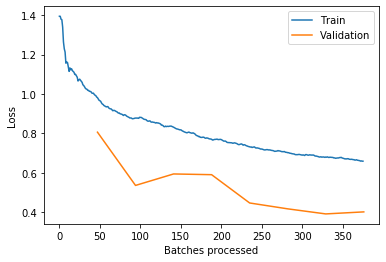

18_448cut_lr_0.02_cyc_8_i1_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.991123,0.787896,0.290541,0.709459,00:32
1,0.878755,0.901377,0.445946,0.554054,00:32
2,0.841902,0.527477,0.182432,0.817568,00:32
3,0.784524,0.519969,0.180180,0.819820,00:32
4,0.737568,0.518104,0.166667,0.833333,00:32
5,0.704848,0.440539,0.132883,0.867117,00:32
6,0.686720,0.425546,0.119369,0.880631,00:32
7,0.662554,0.432014,0.123874,0.876126,00:32


Better model found at epoch 0 with accuracy value: 0.7094594836235046.
Better model found at epoch 2 with accuracy value: 0.8175676465034485.
Better model found at epoch 3 with accuracy value: 0.8198198676109314.
Better model found at epoch 4 with accuracy value: 0.8333333134651184.
Better model found at epoch 5 with accuracy value: 0.867117166519165.
Better model found at epoch 6 with accuracy value: 0.8806306719779968.


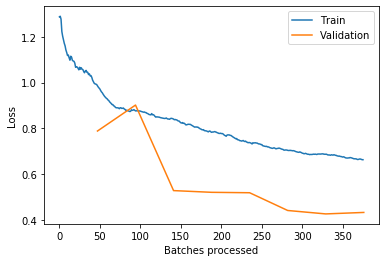

18_448cut_lr_0.02_cyc_8_i2_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.002795,0.983694,0.427928,0.572072,00:32
1,0.884977,0.615773,0.200450,0.799550,00:32
2,0.832131,0.988834,0.520270,0.479730,00:32
3,0.776371,0.498540,0.144144,0.855856,00:32
4,0.738797,0.449542,0.135135,0.864865,00:32
5,0.697577,0.454618,0.121622,0.878378,00:32
6,0.672020,0.432490,0.130631,0.869369,00:32
7,0.658553,0.441825,0.139640,0.860360,00:32


Better model found at epoch 0 with accuracy value: 0.5720720887184143.
Better model found at epoch 1 with accuracy value: 0.7995496392250061.
Better model found at epoch 3 with accuracy value: 0.8558559417724609.
Better model found at epoch 4 with accuracy value: 0.8648649454116821.
Better model found at epoch 5 with accuracy value: 0.8783784508705139.


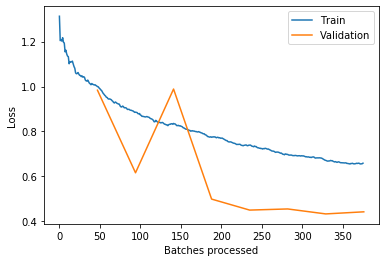

18_448cut_lr_0.02_cyc_8_i3_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.992718,0.953058,0.391892,0.608108,00:32
1,0.888272,1.260008,0.407658,0.592342,00:32
2,0.826909,0.590197,0.234234,0.765766,00:32
3,0.797310,0.485081,0.148649,0.851351,00:32
4,0.749688,0.434696,0.135135,0.864865,00:32
5,0.711983,0.432767,0.110360,0.889640,00:32
6,0.691884,0.422377,0.117117,0.882883,00:32
7,0.659024,0.415436,0.114865,0.885135,00:33


Better model found at epoch 0 with accuracy value: 0.6081081032752991.
Better model found at epoch 2 with accuracy value: 0.7657657861709595.
Better model found at epoch 3 with accuracy value: 0.8513514399528503.
Better model found at epoch 4 with accuracy value: 0.8648649454116821.
Better model found at epoch 5 with accuracy value: 0.8896397352218628.


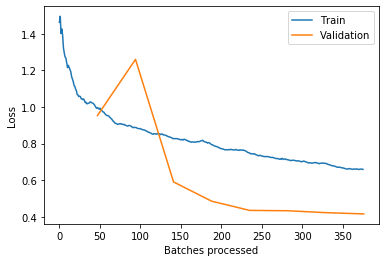

18_448cut_lr_0.02_cyc_8_i4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.011170,1.226575,0.463964,0.536036,00:32
1,0.869994,0.711123,0.279279,0.720721,00:33
2,0.844716,0.598485,0.225225,0.774775,00:32
3,0.784287,0.696191,0.292793,0.707207,00:32
4,0.745656,0.553762,0.168919,0.831081,00:32
5,0.712107,0.438912,0.119369,0.880631,00:32
6,0.687376,0.406644,0.128378,0.871622,00:33
7,0.666533,0.427463,0.139640,0.860360,00:32


Better model found at epoch 0 with accuracy value: 0.5360360145568848.
Better model found at epoch 1 with accuracy value: 0.7207207083702087.
Better model found at epoch 2 with accuracy value: 0.7747747898101807.
Better model found at epoch 4 with accuracy value: 0.8310810923576355.
Better model found at epoch 5 with accuracy value: 0.8806306719779968.


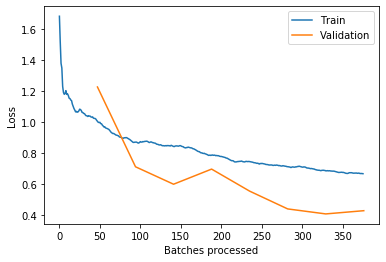

18_448cut_lr_0.02_cyc_8_i5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.072420,1.428713,0.513514,0.486486,00:32
1,0.894917,0.656872,0.231982,0.768018,00:33
2,0.844480,0.573221,0.204955,0.795045,00:32
3,0.785766,0.635806,0.297297,0.702703,00:32
4,0.735842,0.583686,0.213964,0.786036,00:32
5,0.712814,0.421733,0.137387,0.862613,00:32
6,0.680031,0.438780,0.137387,0.862613,00:32
7,0.659839,0.429423,0.135135,0.864865,00:33


Better model found at epoch 0 with accuracy value: 0.4864864945411682.
Better model found at epoch 1 with accuracy value: 0.7680180072784424.
Better model found at epoch 2 with accuracy value: 0.795045018196106.
Better model found at epoch 5 with accuracy value: 0.8626126646995544.
Better model found at epoch 7 with accuracy value: 0.8648649454116821.


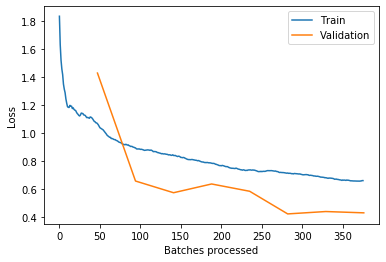

18_448cut_lr_0.02_cyc_8_i6_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.025786,0.799382,0.326577,0.673423,00:33
1,0.896030,1.281265,0.540541,0.459459,00:32
2,0.844926,0.658323,0.216216,0.783784,00:33
3,0.792666,0.467926,0.164414,0.835586,00:33
4,0.745678,0.505883,0.146396,0.853604,00:34
5,0.701533,0.420801,0.123874,0.876126,00:32
6,0.678770,0.434871,0.135135,0.864865,00:32
7,0.663039,0.407105,0.121622,0.878378,00:32


Better model found at epoch 0 with accuracy value: 0.6734234094619751.
Better model found at epoch 2 with accuracy value: 0.7837837934494019.
Better model found at epoch 3 with accuracy value: 0.8355856537818909.
Better model found at epoch 4 with accuracy value: 0.8536036610603333.
Better model found at epoch 5 with accuracy value: 0.8761261701583862.
Better model found at epoch 7 with accuracy value: 0.8783784508705139.


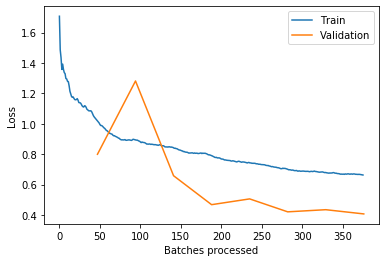

18_448cut_lr_0.02_cyc_8_i7_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.965882,1.383355,0.556306,0.443694,00:32
1,0.869886,0.626944,0.243243,0.756757,00:32
2,0.848218,0.607981,0.265766,0.734234,00:32
3,0.780755,0.512543,0.155405,0.844595,00:32
4,0.732364,0.461197,0.150901,0.849099,00:32
5,0.699802,0.470073,0.148649,0.851351,00:32
6,0.685898,0.437434,0.119369,0.880631,00:32
7,0.657308,0.437924,0.128378,0.871622,00:32


Better model found at epoch 0 with accuracy value: 0.44369369745254517.
Better model found at epoch 1 with accuracy value: 0.7567567825317383.
Better model found at epoch 3 with accuracy value: 0.8445946574211121.
Better model found at epoch 4 with accuracy value: 0.8490991592407227.
Better model found at epoch 5 with accuracy value: 0.8513514399528503.
Better model found at epoch 6 with accuracy value: 0.8806306719779968.


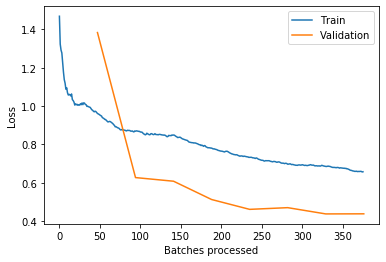

18_448cut_lr_0.02_cyc_8_i8_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.022509,0.722583,0.290541,0.709459,00:32
1,0.871975,1.243559,0.340090,0.659910,00:32
2,0.840218,0.558192,0.189189,0.810811,00:32
3,0.788968,0.492079,0.155405,0.844595,00:32
4,0.739291,0.424323,0.126126,0.873874,00:32
5,0.704401,0.404397,0.114865,0.885135,00:32
6,0.675178,0.412574,0.137387,0.862613,00:32
7,0.659855,0.407325,0.117117,0.882883,00:32


Better model found at epoch 0 with accuracy value: 0.7094594836235046.
Better model found at epoch 2 with accuracy value: 0.8108108639717102.
Better model found at epoch 3 with accuracy value: 0.8445946574211121.
Better model found at epoch 4 with accuracy value: 0.8738739490509033.
Better model found at epoch 5 with accuracy value: 0.8851352334022522.


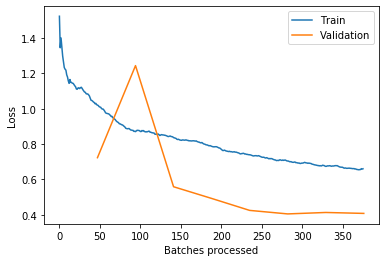

18_448cut_lr_0.02_cyc_8_i9_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.009623,0.649585,0.261261,0.738739,00:32
1,0.872466,0.722517,0.333333,0.666667,00:32
2,0.832546,0.451677,0.148649,0.851351,00:32
3,0.767709,0.602543,0.222973,0.777027,00:32
4,0.732959,0.496171,0.168919,0.831081,00:32
5,0.707140,0.457775,0.132883,0.867117,00:32
6,0.675370,0.417064,0.121622,0.878378,00:32
7,0.663236,0.414983,0.119369,0.880631,00:32


Better model found at epoch 0 with accuracy value: 0.7387387156486511.
Better model found at epoch 2 with accuracy value: 0.8513514399528503.
Better model found at epoch 5 with accuracy value: 0.867117166519165.
Better model found at epoch 6 with accuracy value: 0.8783784508705139.
Better model found at epoch 7 with accuracy value: 0.8806306719779968.


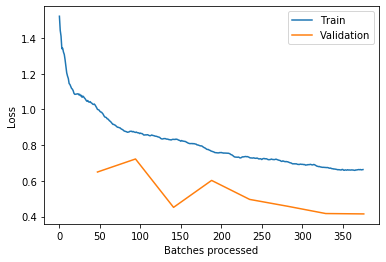

In [22]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
save_stats()

18_448cut_lr_0.02_cyc_16_i0_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.991229,0.898059,0.376126,0.623874,00:32
1,0.874554,0.568425,0.225225,0.774775,00:32
2,0.811239,0.514843,0.164414,0.835586,00:32
3,0.797109,0.562148,0.213964,0.786036,00:32
4,0.778550,0.502592,0.175676,0.824324,00:32
5,0.743606,0.553947,0.182432,0.817568,00:32
6,0.721640,0.746264,0.382883,0.617117,00:32
7,0.710155,0.452110,0.162162,0.837838,00:32
8,0.699363,0.433788,0.135135,0.864865,00:32
9,0.687508,0.508275,0.162162,0.837838,00:32


Better model found at epoch 0 with accuracy value: 0.6238738894462585.
Better model found at epoch 1 with accuracy value: 0.7747748494148254.
Better model found at epoch 2 with accuracy value: 0.8355856537818909.
Better model found at epoch 7 with accuracy value: 0.8378379344940186.
Better model found at epoch 8 with accuracy value: 0.8648649454116821.
Better model found at epoch 12 with accuracy value: 0.9009009599685669.


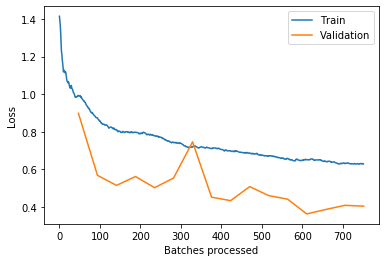

18_448cut_lr_0.02_cyc_16_i1_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.056319,1.048530,0.398649,0.601351,00:32
1,0.900353,0.613244,0.227477,0.772523,00:32
2,0.817054,0.511659,0.171171,0.828829,00:32
3,0.815736,0.549812,0.171171,0.828829,00:32
4,0.791842,0.501098,0.182432,0.817568,00:32
5,0.742651,0.548398,0.222973,0.777027,00:32
6,0.721153,0.492467,0.150901,0.849099,00:32
7,0.711125,0.515907,0.175676,0.824324,00:32
8,0.694446,0.471096,0.153153,0.846847,00:32
9,0.683464,0.527068,0.198198,0.801802,00:32


Better model found at epoch 0 with accuracy value: 0.6013513803482056.
Better model found at epoch 1 with accuracy value: 0.772522509098053.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.
Better model found at epoch 3 with accuracy value: 0.8288288712501526.
Better model found at epoch 6 with accuracy value: 0.8490991592407227.
Better model found at epoch 10 with accuracy value: 0.8603604435920715.
Better model found at epoch 12 with accuracy value: 0.8828829526901245.


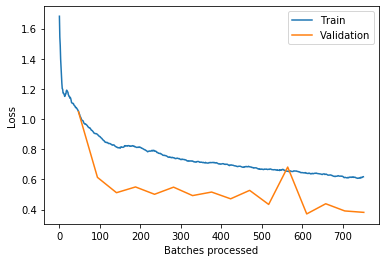

18_448cut_lr_0.02_cyc_16_i2_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.040782,0.810231,0.358108,0.641892,00:32
1,0.876573,0.528505,0.175676,0.824324,00:32
2,0.811208,0.548372,0.186937,0.813063,00:32
3,0.798616,0.700072,0.281531,0.718468,00:32
4,0.770143,0.524107,0.189189,0.810811,00:32
5,0.739545,0.617879,0.245495,0.754505,00:32
6,0.725129,0.485862,0.164414,0.835586,00:32
7,0.713864,0.670488,0.313063,0.686937,00:32
8,0.698079,0.488989,0.139640,0.860360,00:32
9,0.672556,0.434704,0.117117,0.882883,00:32


Better model found at epoch 0 with accuracy value: 0.6418918967247009.
Better model found at epoch 1 with accuracy value: 0.824324369430542.
Better model found at epoch 6 with accuracy value: 0.8355856537818909.
Better model found at epoch 8 with accuracy value: 0.8603604435920715.
Better model found at epoch 9 with accuracy value: 0.8828829526901245.
Better model found at epoch 15 with accuracy value: 0.8851352334022522.


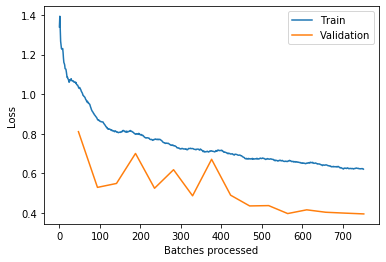

18_448cut_lr_0.02_cyc_16_i3_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.020177,1.070723,0.396396,0.603604,00:32
1,0.870015,0.577459,0.200450,0.799550,00:32
2,0.811054,0.487197,0.159910,0.840090,00:32
3,0.788606,0.522415,0.171171,0.828829,00:32
4,0.765974,0.484961,0.153153,0.846847,00:32
5,0.738011,0.490936,0.184685,0.815315,00:32
6,0.721578,0.443887,0.164414,0.835586,00:32
7,0.699041,0.428707,0.132883,0.867117,00:32
8,0.694414,0.469915,0.146396,0.853604,00:32
9,0.688697,0.540363,0.290541,0.709459,00:32


Better model found at epoch 0 with accuracy value: 0.6036036014556885.
Better model found at epoch 1 with accuracy value: 0.7995496392250061.
Better model found at epoch 2 with accuracy value: 0.8400901556015015.
Better model found at epoch 4 with accuracy value: 0.8468469381332397.
Better model found at epoch 7 with accuracy value: 0.867117166519165.
Better model found at epoch 10 with accuracy value: 0.8693694472312927.
Better model found at epoch 12 with accuracy value: 0.8873874545097351.
Better model found at epoch 13 with accuracy value: 0.8963964581489563.


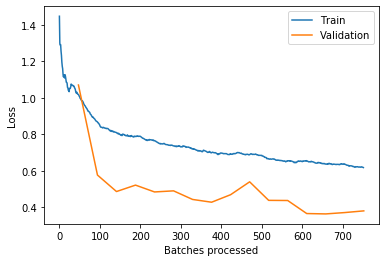

18_448cut_lr_0.02_cyc_16_i4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.010509,1.257893,0.515766,0.484234,00:32
1,0.876651,0.487747,0.153153,0.846847,00:32
2,0.812526,0.788679,0.310811,0.689189,00:32
3,0.814337,0.618740,0.254504,0.745495,00:32
4,0.769885,0.452039,0.148649,0.851351,00:32
5,0.728792,0.528832,0.155405,0.844595,00:32
6,0.721548,0.442229,0.126126,0.873874,00:32
7,0.693644,0.502332,0.171171,0.828829,00:32
8,0.690648,0.486779,0.166667,0.833333,00:32
9,0.676416,0.397483,0.128378,0.871622,00:32


Better model found at epoch 0 with accuracy value: 0.4842342436313629.
Better model found at epoch 1 with accuracy value: 0.8468469381332397.
Better model found at epoch 4 with accuracy value: 0.8513514399528503.
Better model found at epoch 6 with accuracy value: 0.8738739490509033.
Better model found at epoch 10 with accuracy value: 0.9054054617881775.


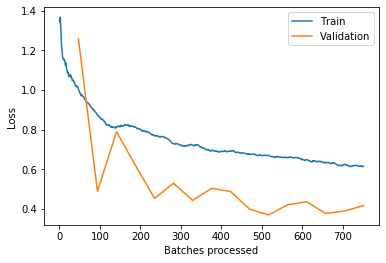

18_448cut_lr_0.02_cyc_16_i5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.015680,0.922888,0.351351,0.648649,00:32
1,0.870490,0.505636,0.159910,0.840090,00:32
2,0.812847,0.513127,0.198198,0.801802,00:32
3,0.786721,0.805759,0.362613,0.637387,00:32
4,0.788300,0.668182,0.322072,0.677928,00:32
5,0.745287,0.654469,0.268018,0.731982,00:32
6,0.730163,0.399596,0.135135,0.864865,00:32
7,0.716698,0.646194,0.254504,0.745495,00:32
8,0.710391,0.385546,0.123874,0.876126,00:32
9,0.687031,0.767683,0.351351,0.648649,00:32


Better model found at epoch 0 with accuracy value: 0.6486486196517944.
Better model found at epoch 1 with accuracy value: 0.8400901556015015.
Better model found at epoch 6 with accuracy value: 0.8648649454116821.
Better model found at epoch 8 with accuracy value: 0.8761261701583862.


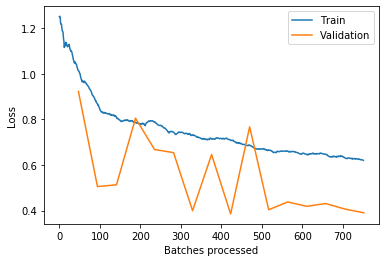

18_448cut_lr_0.02_cyc_16_i6_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.992064,0.778085,0.360360,0.639640,00:32
1,0.869867,0.587946,0.254504,0.745495,00:32
2,0.796923,0.788813,0.297297,0.702703,00:32
3,0.807008,0.650189,0.182432,0.817568,00:32
4,0.773269,0.538411,0.207207,0.792793,00:32
5,0.752102,0.601555,0.222973,0.777027,00:32
6,0.716410,0.435734,0.126126,0.873874,00:32
7,0.706653,0.436175,0.137387,0.862613,00:32
8,0.707141,0.439089,0.121622,0.878378,00:32
9,0.683080,0.487998,0.153153,0.846847,00:32


Better model found at epoch 0 with accuracy value: 0.6396396160125732.
Better model found at epoch 1 with accuracy value: 0.7454954981803894.
Better model found at epoch 3 with accuracy value: 0.8175676465034485.
Better model found at epoch 6 with accuracy value: 0.8738739490509033.
Better model found at epoch 8 with accuracy value: 0.8783784508705139.
Better model found at epoch 10 with accuracy value: 0.8851352334022522.
Better model found at epoch 11 with accuracy value: 0.8941442370414734.
Better model found at epoch 14 with accuracy value: 0.9076577425003052.


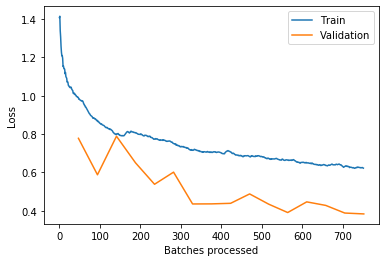

18_448cut_lr_0.02_cyc_16_i7_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.977071,0.836200,0.346847,0.653153,00:32
1,0.853224,0.513133,0.209459,0.790541,00:32
2,0.818490,0.530093,0.186937,0.813063,00:32
3,0.818500,0.599882,0.254504,0.745495,00:32
4,0.787387,0.437625,0.146396,0.853604,00:32
5,0.754048,0.512954,0.164414,0.835586,00:32
6,0.723720,0.487570,0.166667,0.833333,00:32
7,0.710535,0.426726,0.135135,0.864865,00:32
8,0.693077,0.492972,0.146396,0.853604,00:32
9,0.684406,0.518973,0.200450,0.799550,00:32


Better model found at epoch 0 with accuracy value: 0.6531531810760498.
Better model found at epoch 1 with accuracy value: 0.7905406355857849.
Better model found at epoch 2 with accuracy value: 0.8130630850791931.
Better model found at epoch 4 with accuracy value: 0.8536036610603333.
Better model found at epoch 7 with accuracy value: 0.8648649454116821.
Better model found at epoch 10 with accuracy value: 0.8851352334022522.
Better model found at epoch 12 with accuracy value: 0.8896397352218628.


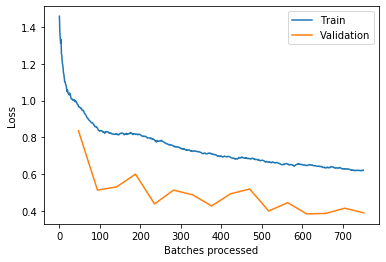

18_448cut_lr_0.02_cyc_16_i8_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.019416,0.634361,0.247748,0.752252,00:32
1,0.881079,0.520276,0.191441,0.808559,00:32
2,0.812572,0.596723,0.240991,0.759009,00:32
3,0.805943,0.611166,0.211712,0.788288,00:32
4,0.797433,0.585403,0.265766,0.734234,00:32
5,0.753499,0.425087,0.130631,0.869369,00:32
6,0.722532,0.487890,0.155405,0.844595,00:32
7,0.711089,0.489748,0.153153,0.846847,00:32
8,0.694563,0.638135,0.236486,0.763514,00:32
9,0.678991,0.454395,0.137387,0.862613,00:32


Better model found at epoch 0 with accuracy value: 0.7522522807121277.
Better model found at epoch 1 with accuracy value: 0.8085586428642273.
Better model found at epoch 5 with accuracy value: 0.8693694472312927.
Better model found at epoch 10 with accuracy value: 0.8963964581489563.


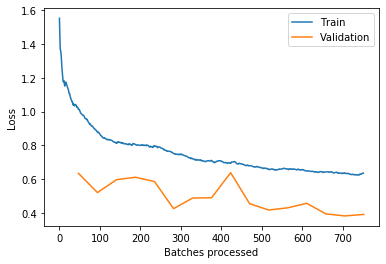

18_448cut_lr_0.02_cyc_16_i9_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.987015,0.957521,0.400901,0.599099,00:32
1,0.873065,0.544568,0.213964,0.786036,00:33
2,0.797311,0.513344,0.184685,0.815315,00:32
3,0.791133,0.597971,0.189189,0.810811,00:32
4,0.779264,0.504643,0.184685,0.815315,00:32
5,0.755910,0.437290,0.153153,0.846847,00:33
6,0.732173,0.714569,0.286036,0.713964,00:32
7,0.719349,0.556171,0.222973,0.777027,00:32
8,0.704836,0.531326,0.177928,0.822072,00:32
9,0.679568,0.618719,0.240991,0.759009,00:32


Better model found at epoch 0 with accuracy value: 0.5990990996360779.
Better model found at epoch 1 with accuracy value: 0.7860360145568848.
Better model found at epoch 2 with accuracy value: 0.815315306186676.
Better model found at epoch 5 with accuracy value: 0.8468469381332397.
Better model found at epoch 11 with accuracy value: 0.867117166519165.
Better model found at epoch 12 with accuracy value: 0.8738739490509033.
Better model found at epoch 13 with accuracy value: 0.8806306719779968.


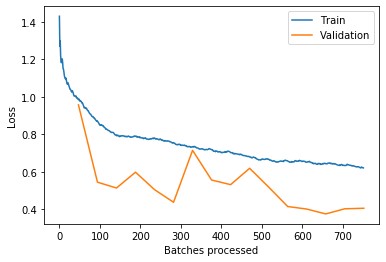

In [26]:
for i in range(10):
    for key, params in get_params(all_cycles=[16], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
save_stats()

18_448cut_lr_0.03_cyc_8_i0_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.949016,1.122982,0.472973,0.527027,00:32
1,0.882072,1.443747,0.531532,0.468468,00:32
2,0.843441,0.559831,0.259009,0.740991,00:32
3,0.788097,0.598223,0.193694,0.806306,00:32
4,0.744482,0.553717,0.245495,0.754505,00:32
5,0.716180,0.507757,0.175676,0.824324,00:32
6,0.683642,0.455468,0.130631,0.869369,00:32
7,0.671094,0.460918,0.141892,0.858108,00:32


Better model found at epoch 0 with accuracy value: 0.5270270109176636.
Better model found at epoch 2 with accuracy value: 0.7409909963607788.
Better model found at epoch 3 with accuracy value: 0.8063063621520996.
Better model found at epoch 5 with accuracy value: 0.824324369430542.
Better model found at epoch 6 with accuracy value: 0.8693694472312927.


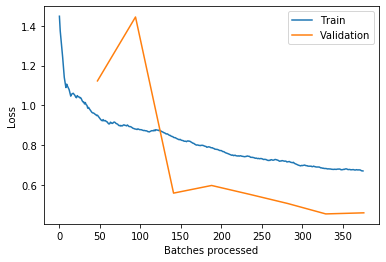

18_448cut_lr_0.03_cyc_8_i1_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.957659,1.546675,0.623874,0.376126,00:32
1,0.892564,1.173442,0.484234,0.515766,00:32
2,0.855915,1.065338,0.394144,0.605856,00:32
3,0.791863,0.476449,0.130631,0.869369,00:32
4,0.743454,0.527306,0.259009,0.740991,00:32
5,0.714344,0.438706,0.128378,0.871622,00:33
6,0.694828,0.441404,0.126126,0.873874,00:32
7,0.666676,0.428751,0.121622,0.878378,00:33


Better model found at epoch 0 with accuracy value: 0.37612614035606384.
Better model found at epoch 1 with accuracy value: 0.5157657861709595.
Better model found at epoch 2 with accuracy value: 0.6058558821678162.
Better model found at epoch 3 with accuracy value: 0.8693694472312927.
Better model found at epoch 5 with accuracy value: 0.8716216683387756.
Better model found at epoch 6 with accuracy value: 0.8738739490509033.
Better model found at epoch 7 with accuracy value: 0.8783784508705139.


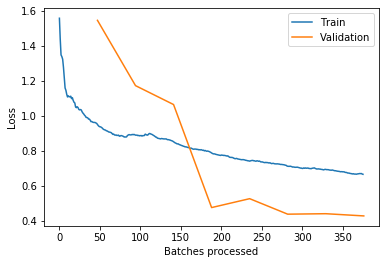

18_448cut_lr_0.03_cyc_8_i2_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.968782,0.794071,0.310811,0.689189,00:32
1,0.875782,1.685224,0.540541,0.459459,00:32
2,0.839410,0.572002,0.252252,0.747748,00:32
3,0.797953,0.437307,0.137387,0.862613,00:32
4,0.741969,0.484282,0.175676,0.824324,00:32
5,0.708013,0.443740,0.128378,0.871622,00:32
6,0.681218,0.511533,0.157658,0.842342,00:33
7,0.657926,0.440590,0.128378,0.871622,00:32


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 2 with accuracy value: 0.7477477192878723.
Better model found at epoch 3 with accuracy value: 0.8626126646995544.
Better model found at epoch 5 with accuracy value: 0.8716216683387756.


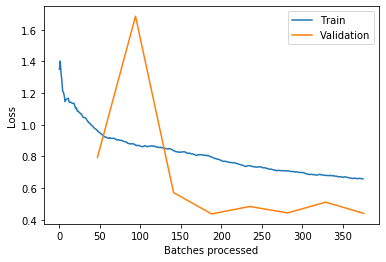

18_448cut_lr_0.03_cyc_8_i3_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.988334,0.732201,0.299550,0.700450,00:32
1,0.875151,0.968612,0.346847,0.653153,00:33
2,0.844653,0.677647,0.265766,0.734234,00:32
3,0.790016,0.498334,0.132883,0.867117,00:32
4,0.738322,0.493358,0.141892,0.858108,00:32
5,0.705551,0.520105,0.191441,0.808559,00:32
6,0.689908,0.519191,0.166667,0.833333,00:32
7,0.654430,0.446173,0.112613,0.887387,00:32


Better model found at epoch 0 with accuracy value: 0.7004504799842834.
Better model found at epoch 2 with accuracy value: 0.7342342138290405.
Better model found at epoch 3 with accuracy value: 0.867117166519165.
Better model found at epoch 7 with accuracy value: 0.8873874545097351.


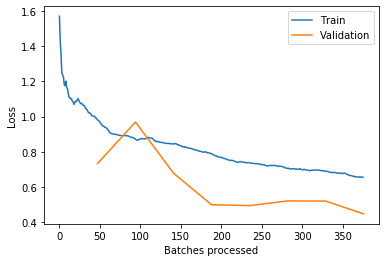

18_448cut_lr_0.03_cyc_8_i4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.963880,0.730687,0.342342,0.657658,00:32
1,0.901062,1.136803,0.398649,0.601351,00:32
2,0.873038,0.680905,0.425676,0.574324,00:32
3,0.810824,0.798126,0.441441,0.558559,00:32
4,0.751514,0.476585,0.157658,0.842342,00:32
5,0.714912,0.445345,0.123874,0.876126,00:33
6,0.688832,0.383235,0.103604,0.896396,00:32
7,0.668765,0.419142,0.121622,0.878378,00:32


Better model found at epoch 0 with accuracy value: 0.6576576828956604.
Better model found at epoch 4 with accuracy value: 0.8423423171043396.
Better model found at epoch 5 with accuracy value: 0.8761261701583862.
Better model found at epoch 6 with accuracy value: 0.8963964581489563.


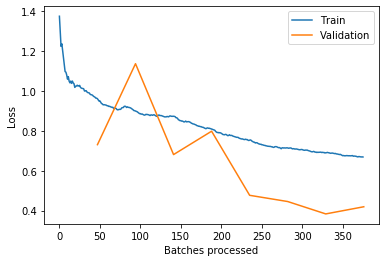

18_448cut_lr_0.03_cyc_8_i5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.974547,0.641780,0.225225,0.774775,00:33
1,0.893258,0.602958,0.182432,0.817568,00:32
2,0.848417,0.646671,0.337838,0.662162,00:33
3,0.789829,0.636855,0.254504,0.745495,00:33
4,0.758466,0.487140,0.164414,0.835586,00:33
5,0.717328,0.557105,0.220721,0.779279,00:32
6,0.682945,0.419514,0.119369,0.880631,00:32
7,0.670693,0.390677,0.114865,0.885135,00:32


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 1 with accuracy value: 0.8175675868988037.
Better model found at epoch 4 with accuracy value: 0.8355855941772461.
Better model found at epoch 6 with accuracy value: 0.8806306719779968.
Better model found at epoch 7 with accuracy value: 0.8851352334022522.


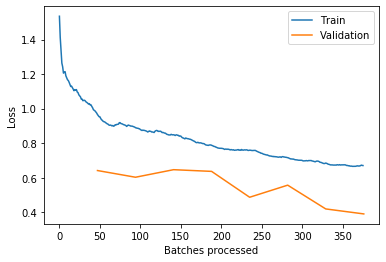

18_448cut_lr_0.03_cyc_8_i6_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.977376,0.735145,0.319820,0.680180,00:32
1,0.877335,1.319802,0.515766,0.484234,00:32
2,0.847751,0.714338,0.279279,0.720721,00:33
3,0.781229,0.586951,0.191441,0.808559,00:32
4,0.743680,0.416492,0.130631,0.869369,00:32
5,0.707344,0.411248,0.117117,0.882883,00:33
6,0.679619,0.388783,0.117117,0.882883,00:32
7,0.663353,0.408331,0.126126,0.873874,00:32


Better model found at epoch 0 with accuracy value: 0.6801801919937134.
Better model found at epoch 2 with accuracy value: 0.7207207083702087.
Better model found at epoch 3 with accuracy value: 0.8085585832595825.
Better model found at epoch 4 with accuracy value: 0.8693694472312927.
Better model found at epoch 5 with accuracy value: 0.8828829526901245.


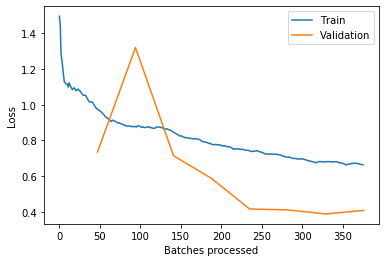

18_448cut_lr_0.03_cyc_8_i7_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.969540,0.572941,0.195946,0.804054,00:32
1,0.917649,0.550249,0.204955,0.795045,00:32
2,0.858696,0.520562,0.166667,0.833333,00:32
3,0.793393,0.591443,0.234234,0.765766,00:32
4,0.751191,0.475867,0.146396,0.853604,00:32
5,0.713295,0.430724,0.126126,0.873874,00:32
6,0.681412,0.451964,0.119369,0.880631,00:32
7,0.666670,0.429679,0.114865,0.885135,00:32


Better model found at epoch 0 with accuracy value: 0.8040540814399719.
Better model found at epoch 2 with accuracy value: 0.8333333730697632.
Better model found at epoch 4 with accuracy value: 0.8536036610603333.
Better model found at epoch 5 with accuracy value: 0.8738739490509033.
Better model found at epoch 6 with accuracy value: 0.8806306719779968.
Better model found at epoch 7 with accuracy value: 0.8851352334022522.


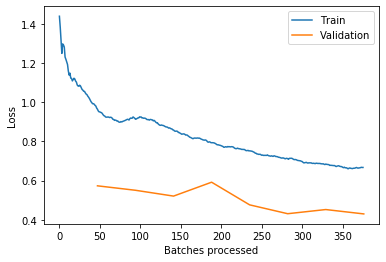

18_448cut_lr_0.03_cyc_8_i8_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.965885,0.694807,0.252252,0.747748,00:32
1,0.884359,1.240443,0.472973,0.527027,00:32
2,0.847001,0.681652,0.250000,0.750000,00:32
3,0.780367,0.584774,0.202703,0.797297,00:32
4,0.739239,0.468171,0.153153,0.846847,00:32
5,0.727305,0.444308,0.105856,0.894144,00:32
6,0.692795,0.408264,0.105856,0.894144,00:32
7,0.681102,0.423108,0.110360,0.889640,00:32


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.75.
Better model found at epoch 3 with accuracy value: 0.7972972989082336.
Better model found at epoch 4 with accuracy value: 0.8468469381332397.
Better model found at epoch 5 with accuracy value: 0.8941442370414734.


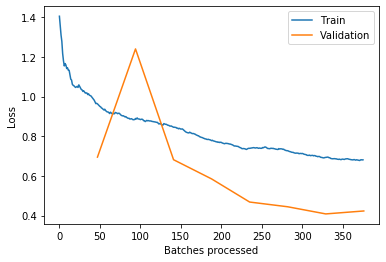

18_448cut_lr_0.03_cyc_8_i9_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.958507,0.963760,0.423423,0.576577,00:32
1,0.904897,0.802042,0.344595,0.655405,00:32
2,0.862900,0.520443,0.202703,0.797297,00:32
3,0.797066,0.726924,0.304054,0.695946,00:32
4,0.740222,0.466190,0.139640,0.860360,00:32
5,0.707155,0.515086,0.193694,0.806306,00:32
6,0.681437,0.428920,0.132883,0.867117,00:32
7,0.660459,0.429758,0.123874,0.876126,00:32


Better model found at epoch 0 with accuracy value: 0.5765765905380249.
Better model found at epoch 1 with accuracy value: 0.6554054021835327.
Better model found at epoch 2 with accuracy value: 0.7972973585128784.
Better model found at epoch 4 with accuracy value: 0.8603604435920715.
Better model found at epoch 6 with accuracy value: 0.867117166519165.
Better model found at epoch 7 with accuracy value: 0.8761261701583862.


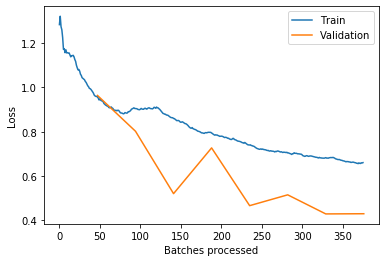

In [27]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
save_stats()

## Summary of Results

In [23]:
for key in [None, 'lr_0.03', 'lr_0.02', 'lr_0.01', 'cyc_4', 'cyc_8', 'cyc_12',  'cyc_16', 
            '_m', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_results, key=key, show_details=False)

Overall         Error -- best: 0.092  med: 0.118   Loss -- best: 0.337  med: 0.408
lr_0.03         Error -- best: 0.101  med: 0.120   Loss -- best: 0.367  med: 0.416
lr_0.02         Error -- best: 0.092  med: 0.116   Loss -- best: 0.337  med: 0.399
lr_0.01         Error -- best: 0.101  med: 0.119   Loss -- best: 0.364  med: 0.409
cyc_4           Error -- best: 0.101  med: 0.124   Loss -- best: 0.389  med: 0.434
cyc_8           Error -- best: 0.095  med: 0.115   Loss -- best: 0.337  med: 0.407
cyc_12          Error -- best: 0.106  med: 0.119   Loss -- best: 0.371  med: 0.406
cyc_16          Error -- best: 0.092  med: 0.107   Loss -- best: 0.363  med: 0.379
_m              Error -- best: 0.092  med: 0.116   Loss -- best: 0.363  med: 0.408
lr_0.02_cyc_8   Error -- best: 0.095  med: 0.115   Loss -- best: 0.337  med: 0.405
lr_0.01_cyc_8   Error -- best: 0.101  med: 0.114   Loss -- best: 0.364  med: 0.394


In [24]:
show_results(all_results, limit=10)

Overall         Error -- best: 0.092  med: 0.118   Loss -- best: 0.337  med: 0.408

18_448cut_lr_0.02_cyc_16_i6_m  error_rate: 0.092   accuracy: 0.908   loss:0.3884
18_448cut_lr_0.02_cyc_16_i4_m  error_rate: 0.095   accuracy: 0.905   loss:0.3686
18_448cut_lr_0.02_cyc_8_i9  error_rate: 0.095   accuracy: 0.905   loss:0.3368
18_448cut_lr_0.02_cyc_8_i0_m  error_rate: 0.099   accuracy: 0.901   loss:0.3912
18_448cut_lr_0.02_cyc_16_i0_m  error_rate: 0.099   accuracy: 0.901   loss:0.3632
18_448cut_lr_0.03_cyc_8_i1  error_rate: 0.101   accuracy: 0.899   loss:0.3879
18_448cut_lr_0.01_cyc_8_i9  error_rate: 0.101   accuracy: 0.899   loss:0.3644
18_448cut_lr_0.03_cyc_4_i2  error_rate: 0.101   accuracy: 0.899   loss:0.3977
18_448cut_lr_0.02_cyc_16_i8_m  error_rate: 0.104   accuracy: 0.896   loss:0.3943
18_448cut_lr_0.01_cyc_8_i6  error_rate: 0.104   accuracy: 0.896   loss:0.3705


In [25]:
for key in ['lr_0.03', 'lr_0.02', 'lr_0.01', 'cyc_4', 'cyc_8', 'cyc_12', 'cyc_16', 
            '_m', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_results, key=key, limit=6)
    print('\n')

lr_0.03         Error -- best: 0.101  med: 0.120   Loss -- best: 0.367  med: 0.416

18_448cut_lr_0.03_cyc_8_i1  error_rate: 0.101   accuracy: 0.899   loss:0.3879
18_448cut_lr_0.03_cyc_4_i2  error_rate: 0.101   accuracy: 0.899   loss:0.3977
18_448cut_lr_0.03_cyc_8_i4_m  error_rate: 0.104   accuracy: 0.896   loss:0.3832
18_448cut_lr_0.03_cyc_8_i8_m  error_rate: 0.106   accuracy: 0.894   loss:0.4083
18_448cut_lr_0.03_cyc_8_i3  error_rate: 0.110   accuracy: 0.890   loss:0.3670
18_448cut_lr_0.03_cyc_8_i9  error_rate: 0.113   accuracy: 0.887   loss:0.3752


lr_0.02         Error -- best: 0.092  med: 0.116   Loss -- best: 0.337  med: 0.399

18_448cut_lr_0.02_cyc_16_i6_m  error_rate: 0.092   accuracy: 0.908   loss:0.3884
18_448cut_lr_0.02_cyc_16_i4_m  error_rate: 0.095   accuracy: 0.905   loss:0.3686
18_448cut_lr_0.02_cyc_8_i9  error_rate: 0.095   accuracy: 0.905   loss:0.3368
18_448cut_lr_0.02_cyc_8_i0_m  error_rate: 0.099   accuracy: 0.901   loss:0.3912
18_448cut_lr_0.02_cyc_16_i0_m  error_r

In [26]:
assert False

AssertionError: 

## Inference

- try composite of 4 learners
- try test-time augmentation

In [57]:
name = '18_448cut_lr_0.02_cyc_16_i6_m'


18_448cut_lr_0.02_cyc_16_i6_m tta=False
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        88%         97%        93%        0.92
normal          97%         88%        99%        0.92
virus           88%         87%        94%        0.88


Overall Accuracy: 90.77%


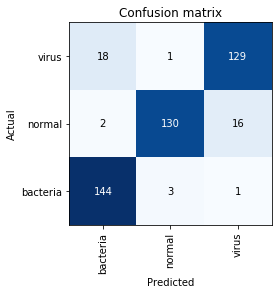

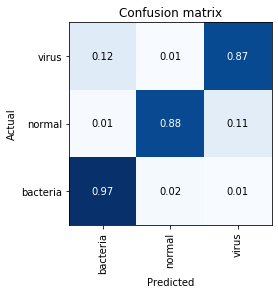

In [28]:
interp = get_interp(name)
print(f'\n{name} tta=False')
analyze_interp(interp)


18_448cut_lr_0.02_cyc_16_i6_m tta=True
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        90%         95%        95%        0.92
normal          98%         83%        99%        0.90
virus           82%         90%        90%        0.86


Overall Accuracy: 89.19%


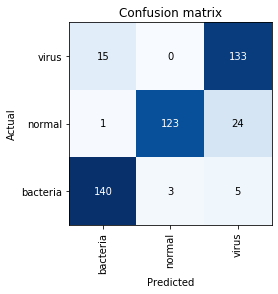

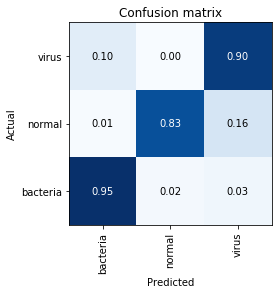

In [29]:
interp = get_interp(name, use_tta=True)
print(f'\n{name} tta=True')
analyze_interp(interp)

In [30]:
top_results = [name for name, _ in sorted(all_results, key=lambda x:x[1]['error_rate'])[:4]]
top_results

['18_448cut_lr_0.02_cyc_16_i6_m',
 '18_448cut_lr_0.02_cyc_16_i4_m',
 '18_448cut_lr_0.02_cyc_8_i9',
 '18_448cut_lr_0.02_cyc_8_i0_m']

In [31]:
top_interp = [[name, get_interp(name)] for name in top_results]

18_448cut_lr_0.02_cyc_16_i6_m
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        88%         97%        93%        0.92
normal          97%         88%        99%        0.92
virus           88%         87%        94%        0.88


Overall Accuracy: 90.77%


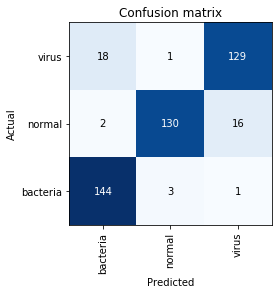

18_448cut_lr_0.02_cyc_16_i4_m
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        88%         95%        93%        0.91
normal          98%         88%        99%        0.93
virus           87%         89%        94%        0.88


Overall Accuracy: 90.77%


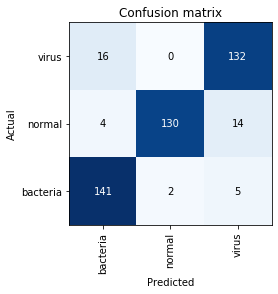

18_448cut_lr_0.02_cyc_8_i9
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        87%         95%        93%        0.91
normal          93%         92%        97%        0.93
virus           92%         84%        96%        0.88


Overall Accuracy: 90.54%


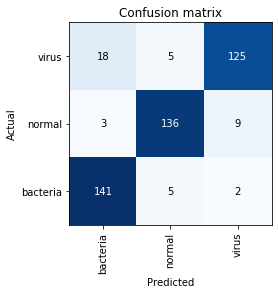

18_448cut_lr_0.02_cyc_8_i0_m
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        88%         96%        93%        0.92
normal          95%         86%        98%        0.90
virus           88%         88%        94%        0.88


Overall Accuracy: 90.09%


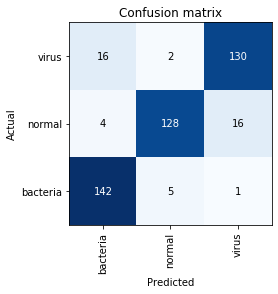

In [32]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

In [33]:
len(top_interp[0])

2

In [55]:
import scipy
from scipy.stats import gmean, hmean

def compute_acc(preds, y_true):
    yy = np.argmax(preds, axis=-1)
    return np.mean(yy==y_true)
    

def combine_predictions(all_interp):
    y_true = to_np(all_interp[0][1].y_true)
    all_preds = np.stack([to_np(interp.preds) for _, interp in all_interp])
    
    preds = np.mean(all_preds, axis=0)
    acc_m = compute_acc(preds, y_true) 
    
    preds = np.median(all_preds, axis=0)
    acc_med = compute_acc(preds, y_true)
    
    preds = gmean(all_preds, axis=0)
    acc_g = compute_acc(preds, y_true)
    
    preds = hmean(all_preds, axis=0)
    acc_h = compute_acc(preds, y_true)
    
    print(f'accuracy -- mean: {acc_m:0.3f}   median: {acc_med:0.3f}   gmean: {acc_g:0.3f}   hmean: {acc_h:0.3f}')
    return acc_m, acc_med, acc_g, acc_h

In [52]:
_ = combine_predictions(top_interp)

accuracy -- mean: 0.919   median: 0.917   gmean: 0.914   hmean: 0.919


### Try again using loss

In [53]:
top_results = [name for name, _ in sorted(all_results, key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

In [56]:
_ = combine_predictions(top_interp)

accuracy -- mean: 0.908   median: 0.912   gmean: 0.908   hmean: 0.910


## Experiment with fine tuning classifier

In [58]:
name = '18_448cut_lr_0.02_cyc_16_i6_m'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06 
Min loss divided by 10: 2.09E-06
Min numerical gradient: 1.10E-06  (smoothed)
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.37E-06


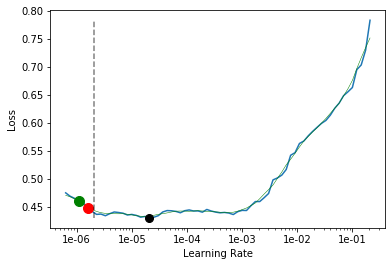

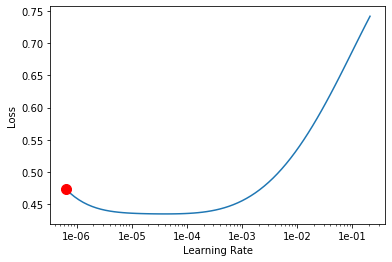

In [49]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [50]:
learn.fit_one_cycle(1, max_lr=slice(2e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.424262,0.416976,0.103604,0.896396,00:32


In [51]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.428860,0.400552,0.108108,0.891892,00:32


In [52]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.441219,0.415550,0.105856,0.894144,00:32
1,0.432410,0.409017,0.103604,0.896396,00:32


In [53]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.443307,0.410066,0.103604,0.896396,00:32
1,0.440207,0.404044,0.099099,0.900901,00:32
2,0.438577,0.399598,0.099099,0.900901,00:32
3,0.433598,0.416032,0.105856,0.894144,00:32


In [54]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.433420,0.414501,0.105856,0.894144,00:32
1,0.431265,0.408399,0.099099,0.900901,00:32
2,0.425577,0.395152,0.099099,0.900901,00:32
3,0.427020,0.412277,0.105856,0.894144,00:32


In [55]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.459243,0.393017,0.105856,0.894144,00:32
1,0.446308,0.390832,0.099099,0.900901,00:32


In [56]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.446005,0.403318,0.110360,0.889640,00:32
1,0.438548,0.390866,0.101351,0.898649,00:32
2,0.432794,0.392861,0.101351,0.898649,00:32
3,0.424497,0.399344,0.101351,0.898649,00:33


In [57]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.449842,0.381912,0.096847,0.903153,00:32
1,0.445799,0.412772,0.112613,0.887387,00:33
2,0.431561,0.404594,0.112613,0.887387,00:32
3,0.418318,0.390962,0.105856,0.894144,00:32


In [58]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(2e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.454566,0.425363,0.105856,0.894144,00:32
1,0.449957,0.413955,0.117117,0.882883,00:32
2,0.435290,0.388772,0.112613,0.887387,00:32
3,0.429098,0.359896,0.101351,0.898649,00:32
4,0.414346,0.403958,0.126126,0.873874,00:32
5,0.395952,0.417790,0.132883,0.867117,00:32
6,0.394802,0.392433,0.110360,0.889640,00:32
7,0.392555,0.398215,0.112613,0.887387,00:32


In [59]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.457123,0.424616,0.103604,0.896396,00:32
1,0.457192,0.419838,0.105856,0.894144,00:32
2,0.458777,0.415795,0.101351,0.898649,00:32
3,0.451102,0.415230,0.099099,0.900901,00:32


In [60]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.454816,0.421495,0.103604,0.896396,00:32
1,0.457112,0.408736,0.103604,0.896396,00:32
2,0.453246,0.412772,0.099099,0.900901,00:32
3,0.455751,0.406854,0.101351,0.898649,00:32
4,0.456580,0.412369,0.099099,0.900901,00:32
5,0.451027,0.416939,0.103604,0.896396,00:32
6,0.447784,0.419458,0.103604,0.896396,00:32
7,0.459968,0.407646,0.105856,0.894144,00:32


In [61]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(1e-6, 1e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.454562,0.415078,0.105856,0.894144,00:32
1,0.450190,0.412349,0.099099,0.900901,00:32
2,0.454199,0.420491,0.099099,0.900901,00:32
3,0.453968,0.413942,0.105856,0.894144,00:32
4,0.450974,0.416251,0.103604,0.896396,00:32
5,0.450646,0.414512,0.099099,0.900901,00:32
6,0.446500,0.407792,0.101351,0.898649,00:32
7,0.448635,0.419578,0.103604,0.896396,00:32
8,0.449446,0.404044,0.099099,0.900901,00:32
9,0.446242,0.408743,0.103604,0.896396,00:32


In [74]:
learn, stats, new_name = refine_learner(name, cycles=2)
stats, new_name

base: {'loss': 0.38838398, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.455708,0.408307,0.099099,0.900901,00:32
1,0.450810,0.418796,0.099099,0.900901,00:32


Better model found at epoch 0 with accuracy value: 0.9009009599685669.
ignoring: {'loss': 0.40830746, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


(None, None)

In [75]:
learn, stats, new_name = refine_learner(name, cycles=8)
stats, new_name

base: {'loss': 0.38838398, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.460549,0.418260,0.099099,0.900901,00:32
1,0.456431,0.410542,0.099099,0.900901,00:32
2,0.465959,0.424944,0.103604,0.896396,00:32
3,0.455267,0.405831,0.101351,0.898649,00:32
4,0.447979,0.409440,0.096847,0.903153,00:32
5,0.448656,0.415795,0.103604,0.896396,00:32
6,0.446936,0.416321,0.105856,0.894144,00:33
7,0.449842,0.410428,0.099099,0.900901,00:32


Better model found at epoch 0 with accuracy value: 0.9009009599685669.
Better model found at epoch 4 with accuracy value: 0.9031532406806946.
ignoring: {'loss': 0.4094402, 'error_rate': 0.09684678912162781, 'accuracy': 0.9031532406806946}


(None, None)

In [94]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=8)
    foo.append([1, stats])
foo

base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.518594,0.427704,0.103604,0.896396,00:33
1,0.510823,0.419936,0.103604,0.896396,00:32
2,0.511371,0.422687,0.105856,0.894144,00:32
3,0.513179,0.425439,0.105856,0.894144,00:32
4,0.500607,0.432682,0.105856,0.894144,00:32
5,0.502864,0.422676,0.103604,0.896396,00:32
6,0.499218,0.444513,0.105856,0.894144,00:32
7,0.503940,0.427511,0.105856,0.894144,00:32


Better model found at epoch 0 with accuracy value: 0.8963964581489563.
ignoring: {'loss': 0.4277044, 'error_rate': 0.1036035418510437, 'accuracy': 0.8963964581489563}
base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.510906,0.414777,0.103604,0.896396,00:32
1,0.511221,0.425986,0.101351,0.898649,00:32
2,0.513172,0.432127,0.105856,0.894144,00:32
3,0.510845,0.433587,0.105856,0.894144,00:32
4,0.505746,0.431259,0.103604,0.896396,00:32
5,0.504225,0.422886,0.105856,0.894144,00:32
6,0.496649,0.446705,0.112613,0.887387,00:32
7,0.495196,0.425130,0.103604,0.896396,00:32


Better model found at epoch 0 with accuracy value: 0.8963964581489563.
Better model found at epoch 1 with accuracy value: 0.898648738861084.
ignoring: {'loss': 0.42598626, 'error_rate': 0.1013512909412384, 'accuracy': 0.898648738861084}
base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.510346,0.432531,0.105856,0.894144,00:32
1,0.508858,0.426037,0.101351,0.898649,00:32
2,0.504345,0.438910,0.108108,0.891892,00:32
3,0.502853,0.435490,0.108108,0.891892,00:32
4,0.498172,0.431084,0.101351,0.898649,00:32
5,0.494541,0.435612,0.101351,0.898649,00:32
6,0.490052,0.426897,0.103604,0.896396,00:32
7,0.498432,0.427513,0.103604,0.896396,00:32


Better model found at epoch 0 with accuracy value: 0.8941442370414734.
Better model found at epoch 1 with accuracy value: 0.898648738861084.
ignoring: {'loss': 0.42603666, 'error_rate': 0.1013512909412384, 'accuracy': 0.898648738861084}
base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.514490,0.424301,0.101351,0.898649,00:32
1,0.511555,0.431974,0.101351,0.898649,00:32
2,0.500667,0.437509,0.103604,0.896396,00:32
3,0.494143,0.429144,0.105856,0.894144,00:32
4,0.501539,0.422732,0.101351,0.898649,00:32
5,0.503372,0.423710,0.101351,0.898649,00:32
6,0.499655,0.428034,0.105856,0.894144,00:32
7,0.498237,0.441464,0.108108,0.891892,00:32


Better model found at epoch 0 with accuracy value: 0.898648738861084.
ignoring: {'loss': 0.42430073, 'error_rate': 0.1013512909412384, 'accuracy': 0.898648738861084}
base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.519726,0.428910,0.101351,0.898649,00:32
1,0.512800,0.430027,0.103604,0.896396,00:32
2,0.511829,0.429342,0.101351,0.898649,00:32
3,0.511940,0.436751,0.103604,0.896396,00:32
4,0.508181,0.431510,0.105856,0.894144,00:32
5,0.498487,0.432543,0.103604,0.896396,00:32
6,0.501248,0.433774,0.105856,0.894144,00:32
7,0.505077,0.433053,0.105856,0.894144,00:32


Better model found at epoch 0 with accuracy value: 0.898648738861084.
ignoring: {'loss': 0.42890972, 'error_rate': 0.1013512909412384, 'accuracy': 0.898648738861084}
base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.502365,0.434948,0.101351,0.898649,00:32
1,0.504648,0.430386,0.108108,0.891892,00:32
2,0.514407,0.437686,0.105856,0.894144,00:32
3,0.508334,0.420712,0.101351,0.898649,00:32
4,0.503965,0.428876,0.105856,0.894144,00:32
5,0.501748,0.422803,0.103604,0.896396,00:33
6,0.493462,0.422178,0.101351,0.898649,00:32
7,0.498060,0.426220,0.103604,0.896396,00:32


Better model found at epoch 0 with accuracy value: 0.898648738861084.
ignoring: {'loss': 0.43494788, 'error_rate': 0.1013512909412384, 'accuracy': 0.898648738861084}
base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.512220,0.428060,0.103604,0.896396,00:32
1,0.506711,0.424124,0.099099,0.900901,00:34
2,0.506134,0.424324,0.105856,0.894144,00:32
3,0.503572,0.427764,0.103604,0.896396,00:32
4,0.507304,0.437415,0.105856,0.894144,00:32
5,0.507288,0.424910,0.103604,0.896396,00:32
6,0.502405,0.431509,0.105856,0.894144,00:32
7,0.505421,0.435350,0.105856,0.894144,00:32


Better model found at epoch 0 with accuracy value: 0.8963964581489563.
Better model found at epoch 1 with accuracy value: 0.9009009599685669.
ignoring: {'loss': 0.42412373, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}
base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.502569,0.426807,0.103604,0.896396,00:32
1,0.511630,0.430206,0.105856,0.894144,00:32
2,0.504568,0.428891,0.101351,0.898649,00:32
3,0.500757,0.430626,0.105856,0.894144,00:32
4,0.500168,0.443461,0.103604,0.896396,00:32
5,0.498531,0.443711,0.108108,0.891892,00:32
6,0.501610,0.423452,0.103604,0.896396,00:32
7,0.500273,0.432976,0.105856,0.894144,00:33


Better model found at epoch 0 with accuracy value: 0.8963964581489563.
Better model found at epoch 2 with accuracy value: 0.898648738861084.
ignoring: {'loss': 0.42889073, 'error_rate': 0.1013512909412384, 'accuracy': 0.898648738861084}
base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.511105,0.429347,0.099099,0.900901,00:33
1,0.508875,0.432786,0.105856,0.894144,00:33
2,0.503605,0.420547,0.103604,0.896396,00:33
3,0.512670,0.427727,0.103604,0.896396,00:32
4,0.497022,0.434555,0.108108,0.891892,00:32
5,0.500285,0.419212,0.101351,0.898649,00:32
6,0.503811,0.422162,0.105856,0.894144,00:33
7,0.505379,0.433236,0.103604,0.896396,00:33


Better model found at epoch 0 with accuracy value: 0.9009009599685669.
ignoring: {'loss': 0.429347, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}
base: {'loss': 0.39121708, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.520046,0.422822,0.101351,0.898649,00:32
1,0.510542,0.438200,0.103604,0.896396,00:33
2,0.506027,0.442250,0.105856,0.894144,00:33
3,0.505780,0.445381,0.103604,0.896396,00:32
4,0.499313,0.433817,0.103604,0.896396,00:33
5,0.503247,0.430838,0.103604,0.896396,00:33
6,0.498367,0.434944,0.103604,0.896396,00:33
7,0.498200,0.432186,0.103604,0.896396,00:33


Better model found at epoch 0 with accuracy value: 0.898648738861084.
ignoring: {'loss': 0.42282236, 'error_rate': 0.1013512909412384, 'accuracy': 0.898648738861084}


[[1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None]]

In [59]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=16)
    foo.append([1, stats])
    print('\n')
foo

base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.454414,0.414617,0.105856,0.894144,00:32
1,0.452925,0.415375,0.103604,0.896396,00:32
2,0.459003,0.410891,0.105856,0.894144,00:32
3,0.451100,0.404924,0.103604,0.896396,00:32
4,0.454499,0.405868,0.103604,0.896396,00:32
5,0.451325,0.410898,0.101351,0.898649,00:32
6,0.448973,0.415558,0.101351,0.898649,00:32
7,0.447396,0.408315,0.103604,0.896396,00:32
8,0.450020,0.405672,0.096847,0.903153,00:32
9,0.447761,0.408350,0.101351,0.898649,00:32


Better model found at epoch 0 with accuracy value: 0.8941442370414734.
Better model found at epoch 1 with accuracy value: 0.8963964581489563.
Better model found at epoch 5 with accuracy value: 0.898648738861084.
Better model found at epoch 8 with accuracy value: 0.9031532406806946.
ignoring: {'loss': 0.40567175, 'error_rate': 0.09684678912162781, 'accuracy': 0.9031532406806946}


base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.462848,0.422415,0.103604,0.896396,00:32
1,0.455901,0.415696,0.099099,0.900901,00:32
2,0.460037,0.415289,0.096847,0.903153,00:32
3,0.454075,0.409484,0.103604,0.896396,00:32
4,0.452226,0.406074,0.103604,0.896396,00:32
5,0.452133,0.410756,0.099099,0.900901,00:32
6,0.447525,0.414957,0.099099,0.900901,00:32
7,0.443124,0.420600,0.101351,0.898649,00:32
8,0.445491,0.419456,0.105856,0.894144,00:32
9,0.446481,0.399748,0.099099,0.900901,00:32


Better model found at epoch 0 with accuracy value: 0.8963964581489563.
Better model found at epoch 1 with accuracy value: 0.9009009599685669.
Better model found at epoch 2 with accuracy value: 0.9031532406806946.
ignoring: {'loss': 0.4152889, 'error_rate': 0.09684678912162781, 'accuracy': 0.9031532406806946}


base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.442855,0.415583,0.105856,0.894144,00:32
1,0.449672,0.420660,0.101351,0.898649,00:32
2,0.453179,0.410347,0.103604,0.896396,00:32
3,0.456080,0.411968,0.101351,0.898649,00:32
4,0.456594,0.419621,0.101351,0.898649,00:32
5,0.451405,0.405183,0.101351,0.898649,00:32
6,0.447146,0.412713,0.103604,0.896396,00:34
7,0.450185,0.401871,0.099099,0.900901,00:32
8,0.451516,0.414551,0.101351,0.898649,00:32
9,0.449964,0.417660,0.103604,0.896396,00:32


Better model found at epoch 0 with accuracy value: 0.8941442370414734.
Better model found at epoch 1 with accuracy value: 0.898648738861084.
Better model found at epoch 7 with accuracy value: 0.9009009599685669.
ignoring: {'loss': 0.40187135, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.448441,0.417625,0.099099,0.900901,00:32
1,0.451585,0.413535,0.099099,0.900901,00:32
2,0.454432,0.430475,0.108108,0.891892,00:32
3,0.453270,0.416438,0.103604,0.896396,00:32
4,0.453795,0.415791,0.101351,0.898649,00:32
5,0.452381,0.416814,0.103604,0.896396,00:32
6,0.453346,0.413289,0.103604,0.896396,00:32
7,0.452125,0.409752,0.103604,0.896396,00:32
8,0.455265,0.406153,0.103604,0.896396,00:32
9,0.449572,0.403983,0.096847,0.903153,00:32


Better model found at epoch 0 with accuracy value: 0.9009009599685669.
Better model found at epoch 9 with accuracy value: 0.9031532406806946.
ignoring: {'loss': 0.40398332, 'error_rate': 0.09684678912162781, 'accuracy': 0.9031532406806946}


base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.466275,0.420942,0.103604,0.896396,00:32
1,0.452765,0.400821,0.096847,0.903153,00:32
2,0.452646,0.412980,0.101351,0.898649,00:32
3,0.456080,0.403780,0.103604,0.896396,00:32
4,0.454734,0.412425,0.099099,0.900901,00:32
5,0.454330,0.407390,0.101351,0.898649,00:32
6,0.447628,0.402752,0.101351,0.898649,00:32
7,0.448370,0.413722,0.103604,0.896396,00:32
8,0.450707,0.402503,0.101351,0.898649,00:32
9,0.447207,0.412691,0.103604,0.896396,00:32


Better model found at epoch 0 with accuracy value: 0.8963964581489563.
Better model found at epoch 1 with accuracy value: 0.9031532406806946.
ignoring: {'loss': 0.40082082, 'error_rate': 0.09684678912162781, 'accuracy': 0.9031532406806946}


base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.450716,0.421179,0.099099,0.900901,00:32
1,0.455147,0.410041,0.099099,0.900901,00:32
2,0.452557,0.414071,0.094595,0.905405,00:32
3,0.452723,0.419680,0.101351,0.898649,00:32
4,0.454483,0.405944,0.105856,0.894144,00:32
5,0.450326,0.423797,0.103604,0.896396,00:32
6,0.449429,0.412788,0.101351,0.898649,00:32
7,0.451940,0.411483,0.103604,0.896396,00:32
8,0.445765,0.405451,0.103604,0.896396,00:32
9,0.447163,0.394068,0.101351,0.898649,00:32


Better model found at epoch 0 with accuracy value: 0.9009009599685669.
Better model found at epoch 2 with accuracy value: 0.9054054617881775.
ignoring: {'loss': 0.4140708, 'error_rate': 0.09459453076124191, 'accuracy': 0.9054054617881775}


base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.452210,0.428987,0.103604,0.896396,00:32
1,0.447024,0.423819,0.105856,0.894144,00:32
2,0.446422,0.414655,0.101351,0.898649,00:32
3,0.450517,0.410412,0.105856,0.894144,00:32
4,0.455079,0.410960,0.103604,0.896396,00:34
5,0.455527,0.414731,0.105856,0.894144,00:32
6,0.457019,0.416248,0.103604,0.896396,00:32
7,0.458260,0.402127,0.103604,0.896396,00:32
8,0.459046,0.408553,0.101351,0.898649,00:32
9,0.460345,0.411166,0.105856,0.894144,00:32


Better model found at epoch 0 with accuracy value: 0.8963964581489563.
Better model found at epoch 2 with accuracy value: 0.898648738861084.
ignoring: {'loss': 0.41465476, 'error_rate': 0.1013512909412384, 'accuracy': 0.898648738861084}


base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.450447,0.410598,0.101351,0.898649,00:32
1,0.454998,0.409355,0.099099,0.900901,00:32
2,0.452158,0.414812,0.099099,0.900901,00:32
3,0.447937,0.413776,0.101351,0.898649,00:32
4,0.452370,0.411373,0.103604,0.896396,00:32
5,0.449339,0.409850,0.099099,0.900901,00:32
6,0.449357,0.413623,0.099099,0.900901,00:32
7,0.454078,0.428908,0.108108,0.891892,00:32
8,0.449975,0.416963,0.108108,0.891892,00:32
9,0.444524,0.417435,0.101351,0.898649,00:32


Better model found at epoch 0 with accuracy value: 0.898648738861084.
Better model found at epoch 1 with accuracy value: 0.9009009599685669.
ignoring: {'loss': 0.4093549, 'error_rate': 0.0990990400314331, 'accuracy': 0.9009009599685669}


base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.451399,0.417832,0.103604,0.896396,00:32
1,0.448368,0.411752,0.103604,0.896396,00:32
2,0.456056,0.406289,0.105856,0.894144,00:32
3,0.456778,0.410064,0.099099,0.900901,00:32
4,0.453221,0.413150,0.103604,0.896396,00:32
5,0.449955,0.402778,0.103604,0.896396,00:32
6,0.451603,0.409253,0.103604,0.896396,00:32
7,0.445695,0.411575,0.099099,0.900901,00:32
8,0.448109,0.415241,0.099099,0.900901,00:32
9,0.448938,0.415243,0.105856,0.894144,00:32


Better model found at epoch 0 with accuracy value: 0.8963964581489563.
Better model found at epoch 3 with accuracy value: 0.9009009599685669.
Better model found at epoch 11 with accuracy value: 0.9031532406806946.
Better model found at epoch 14 with accuracy value: 0.9054054617881775.
ignoring: {'loss': 0.4017052, 'error_rate': 0.09459453076124191, 'accuracy': 0.9054054617881775}


base: {'loss': 0.38837776, 'error_rate': 0.09234227985143661, 'accuracy': 0.9076577425003052}


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.450847,0.420197,0.101351,0.898649,00:32
1,0.458342,0.413990,0.099099,0.900901,00:32
2,0.454244,0.424367,0.103604,0.896396,00:32
3,0.458035,0.417682,0.105856,0.894144,00:32
4,0.445377,0.416536,0.101351,0.898649,00:32
5,0.450931,0.417581,0.105856,0.894144,00:32
6,0.448930,0.415363,0.105856,0.894144,00:32
7,0.458503,0.398949,0.096847,0.903153,00:32
8,0.450506,0.413633,0.103604,0.896396,00:32
9,0.448676,0.415714,0.101351,0.898649,00:32


Better model found at epoch 0 with accuracy value: 0.898648738861084.
Better model found at epoch 1 with accuracy value: 0.9009009599685669.
Better model found at epoch 7 with accuracy value: 0.9031532406806946.
ignoring: {'loss': 0.39894888, 'error_rate': 0.09684678912162781, 'accuracy': 0.9031532406806946}




[[1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None],
 [1, None]]